In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
KIND = 'CFFEX沪深300期货'

In [96]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/len(df))-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:KIND})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                   'max_drawdown_start':[max_drawdown_start_str],
                   'max_drawdown_end':[max_drawdown_end_str],
                   'max_drawdown_last_Y':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[KIND]).T
    return output_df, df, df_return_per_year

# 行情数据处理

In [98]:
ChangeData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH_change.xlsx').set_index('date')
PriceData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH.CFE.xlsx').set_index('date')
cPriceData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH.CFEclose.xlsx').set_index('date')
iReturnData = cPriceData/PriceData-1

In [99]:
# 替换收益率 - 主力合约更换
KIND = 'CFFEX沪深300期货'

ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
PriceDataKIND = PriceData[[KIND]].dropna()
iReturnDataKIND = iReturnData[[KIND]].dropna()
ChangeDataKIND = ChangeData[[KIND]].dropna()
ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

# start = '2010-04-19'
# end = '2019-07-19'
# ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
# PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
# iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
ReturnDataKINDChange = ReturnDataKIND.shift(-1).merge(ChangeDfKIND,left_index=True,right_index=True).copy()
ReturnDataKINDChange[KIND] = ReturnDataKINDChange.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)
ReturnDataKINDChange = ReturnDataKINDChange[[KIND]]

In [100]:
# 原期货是否盈利
IfReturnDataKINDChange = ReturnDataKINDChange.copy()
IfReturnDataKINDChange[KIND] = IfReturnDataKINDChange[KIND].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

# 持仓量数据读取

In [101]:
PositionVDf = pd.DataFrame()
for i in range(1,5):
    PositionVDf = pd.concat([PositionVDf,pd.read_excel('C:/Users/Thinkpad/Desktop/四类合约数据.xlsx',sheet_name='Sheet%d'%(i))])
PositionVDf['月合约代码'] = PositionVDf['月合约代码'].apply(lambda x: x[:-4])
PositionVDf = PositionVDf.rename(columns={'月合约代码':'合约名称'})

In [102]:
PositionVDf_PVT = PositionVDf.pivot_table(index='日期',columns='合约名称',values='持仓量')
PositionVDf_PVT = PositionVDf_PVT - PositionVDf_PVT.shift(1)

In [103]:
PositionVDf_DeltaV = PositionVDf_PVT.unstack().reset_index().rename(columns={0:'持仓量增量'}).merge(PositionVDf,on=['日期','合约名称'])

# 中金所持仓量数据读取

In [104]:
LongShortDelta = {}
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']

nameChangeDict = {'持买单':'多单持仓增量','持卖单':'空单持仓增量','成交':'成交量增量'}
nameChangeDict_ = {'持买单':'多单持仓量','持卖单':'空单持仓量','成交':'成交量'}

for KIND in KINDList:
    LongShortDeltaDf = {}
    for LongOrShortOrV in ['持买单','持卖单','成交']:
        DfDeltaV = pd.read_excel('C:/Users/Thinkpad/Desktop/'+KIND_DICT[KIND]+LongOrShortOrV+'量排名蜘蛛网策略数据更新至20190722.xlsx')
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '华泰期货' if x == '华泰长城' else x)
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '五矿经易' if x == '五矿期货' else x)
        DfDeltaV['日期'] = DfDeltaV['日期'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d'))

        DfDeltaV = DfDeltaV.rename(columns={'变化量':nameChangeDict[LongOrShortOrV],
                                           '量':nameChangeDict_[LongOrShortOrV]})[['日期','公司','合约名称',nameChangeDict[LongOrShortOrV],nameChangeDict_[LongOrShortOrV]]]
        LongShortDeltaDf[LongOrShortOrV] = DfDeltaV
            
    LongShortDelta[KIND] = LongShortDeltaDf
    break

In [105]:
LongShortDeltaDf = LongShortDelta[KIND]

In [106]:
# 每天每个上榜合约持仓量
EachContractV = LongShortDeltaDf['持买单'].groupby(['日期','合约名称']).max().reset_index()[['日期','合约名称']].merge(PositionVDf,on=['日期','合约名称'])

In [107]:
# 每天所有上榜合约持仓量总和
TolContractV = EachContractV.groupby('日期').sum()

# 策略12 ∑B今 Vs ∑B昨 系列

## 策略12-1 ∑B_t/总B_t - ∑B_t-1/总B_t-1

In [34]:
LongShortTolVandDV = pd.concat([LongShortDeltaDf['持买单'].groupby('日期').sum(),LongShortDeltaDf['持卖单'].groupby('日期').sum()],axis=1)

In [36]:
LongShortTolVandDVandPosV = LongShortTolVandDV.merge(TolContractV,left_index=True,right_index=True)

In [38]:
LongShortTolVandDVandPosV['sumB_TolB'] = LongShortTolVandDVandPosV['多单持仓量']/LongShortTolVandDVandPosV['持仓量']
LongShortTolVandDVandPosV['sumS_TolS'] = LongShortTolVandDVandPosV['空单持仓量']/LongShortTolVandDVandPosV['持仓量']

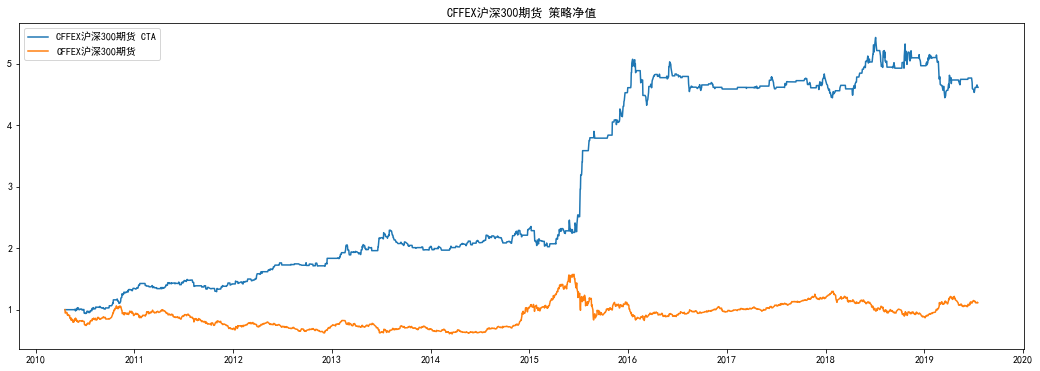

CFFEX沪深300期货胜率0.5295
CFFEX沪深300期货信号频率0.3997
CFFEX沪深300期货信号数量899
CFFEX沪深300期货正负信号比例0.9168
CFFEX沪深300期货信号IR值1.8313
多头窗口25 空头窗口27
                               CFFEX沪深300期货
mean_return                        0.183905
vol_return                         0.159453
IR                                  1.15335
sharpe_ratio                       0.965207
max_drawdown                       0.180559
mean_return_max_drawdown_ratio      1.01853
max_drawdown_start               2018-07-05
max_drawdown_end                 2019-03-18
max_drawdown_last_Y                 0.70089
------------------------------------------------------------------------


In [202]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(20,40,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
        MALong, MAShort = 25,27
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = LongShortTolVandDVandPosV.copy()
        SignalDataKIND['sumB_TolB_DMA'] = SignalDataKIND['sumB_TolB'] - SignalDataKIND['sumB_TolB'].rolling(MALong).mean()
        SignalDataKIND['sumS_TolS_DMA'] = SignalDataKIND['sumS_TolS'] - SignalDataKIND['sumS_TolS'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['sumB_TolB_DMA']>0 and x['sumS_TolS_DMA']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['sumB_TolB_DMA']<0 and x['sumS_TolS_DMA']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

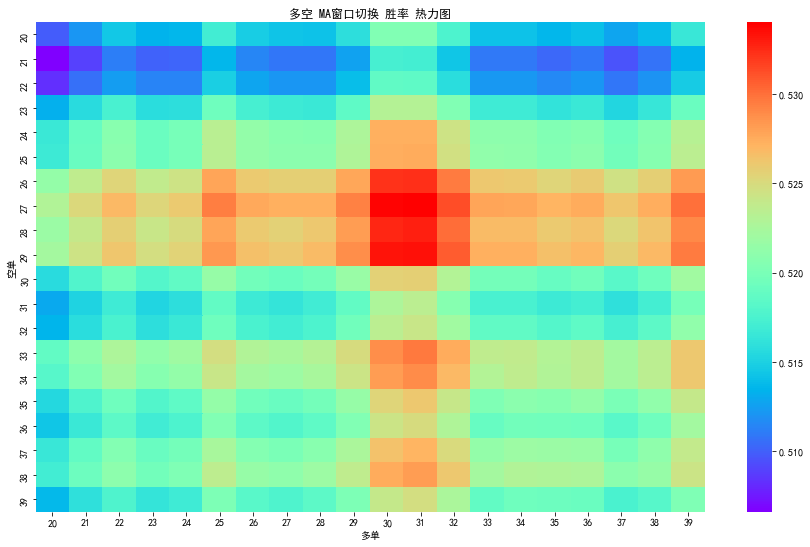

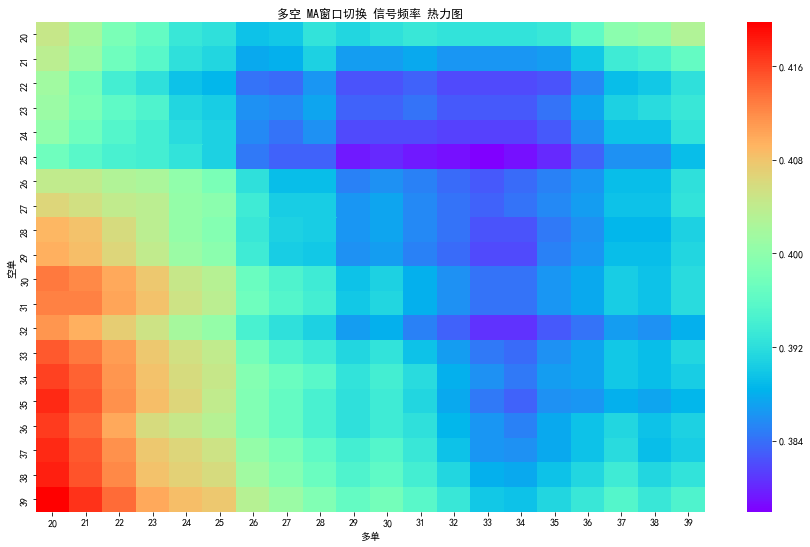

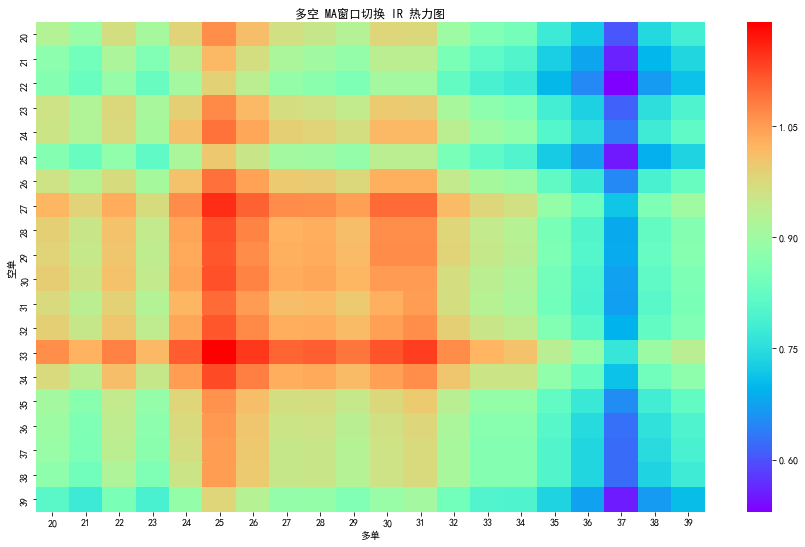

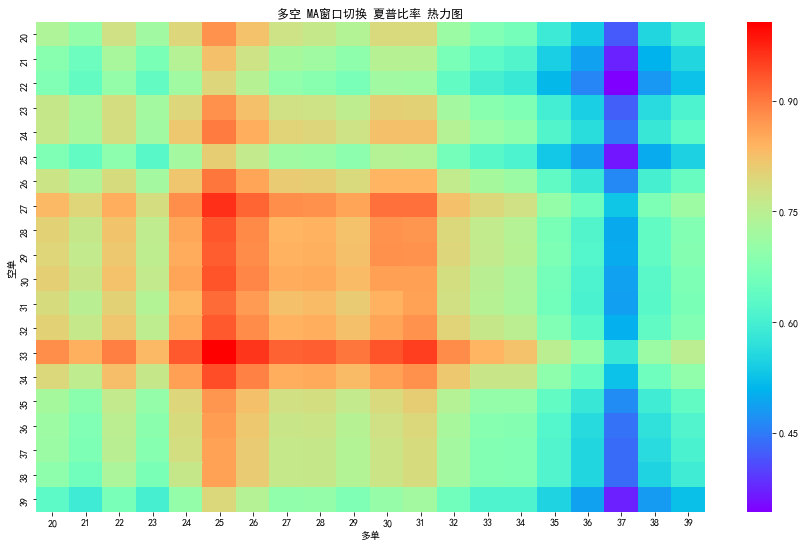

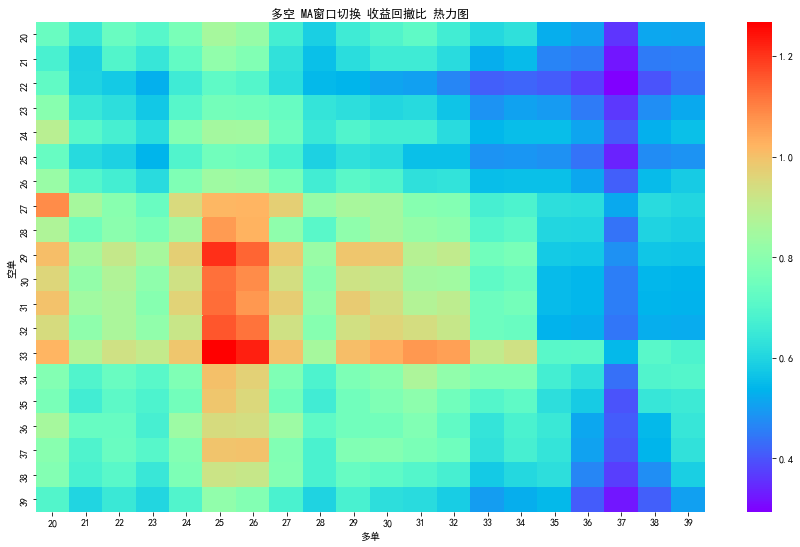

In [75]:
key_name={'WinProb':'胜率','SignalFreq':'信号频率','IR':'IR','sharpe_ratio':'夏普比率','return_max_drawdown_ratio':'收益回撤比',}
for key in LongShortMADict.keys():
    LongShortMADf=pd.DataFrame(LongShortMADict[key],dtype=np.float)
    plt.figure(figsize=(15,9))
    seaborn.heatmap(LongShortMADf,cmap='rainbow')
    plt.xlabel('多单')
    plt.ylabel('空单')
    plt.title('多空 MA窗口切换 %s 热力图'%(key_name[key]))
    plt.show()

## 策略12-2 ∑B_t - ∑B_t-1

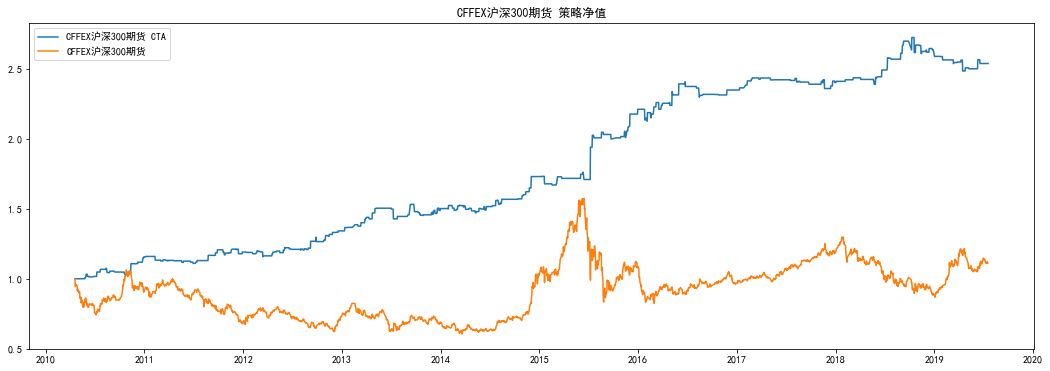

CFFEX沪深300期货胜率0.5859
CFFEX沪深300期货信号频率0.1321
CFFEX沪深300期货信号数量297
CFFEX沪深300期货正负信号比例0.9933
CFFEX沪深300期货信号IR值3.2465
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                         0.10875
vol_return                        0.0937251
IR                                  1.16031
sharpe_ratio                       0.840225
max_drawdown                      0.0879412
mean_return_max_drawdown_ratio      1.23662
max_drawdown_start               2018-10-18
max_drawdown_end                 2019-04-16
max_drawdown_last_Y                0.492813
------------------------------------------------------------------------


In [201]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
        MALong, MAShort = 2,2
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = LongShortTolVandDVandPosV.copy()
        SignalDataKIND['多单持仓量_DMA'] = SignalDataKIND['多单持仓量'] - SignalDataKIND['多单持仓量'].rolling(MALong).mean()
        SignalDataKIND['空单持仓量_DMA'] = SignalDataKIND['空单持仓量'] - SignalDataKIND['空单持仓量'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓量_DMA']>0 and x['空单持仓量_DMA']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓量_DMA']<0 and x['空单持仓量_DMA']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

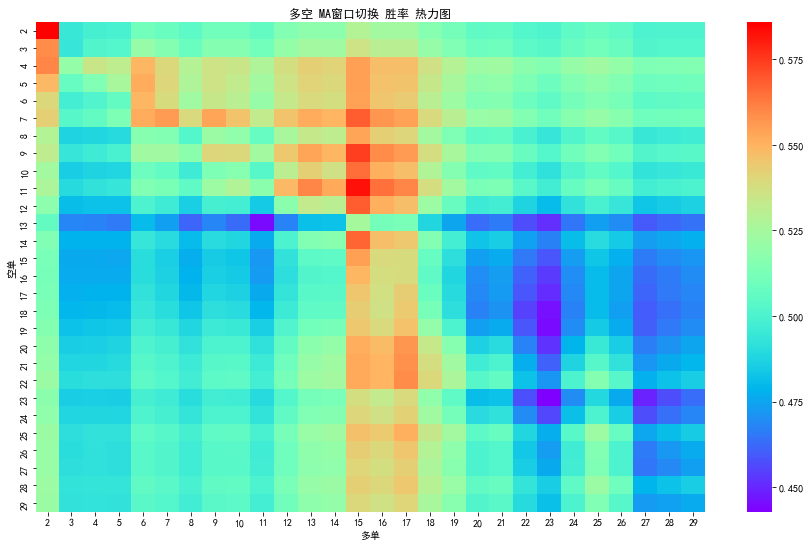

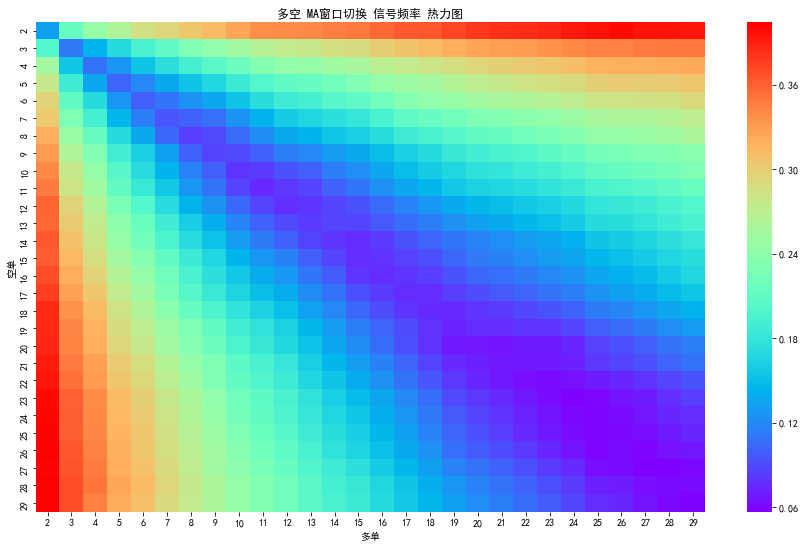

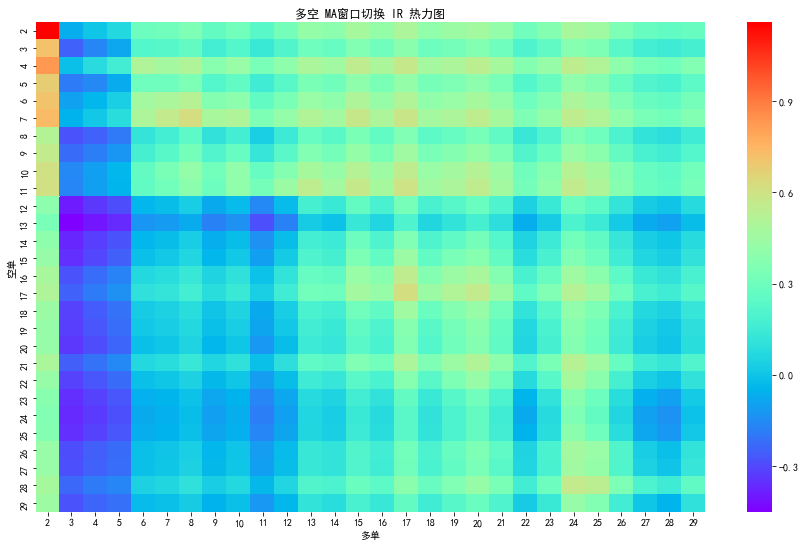

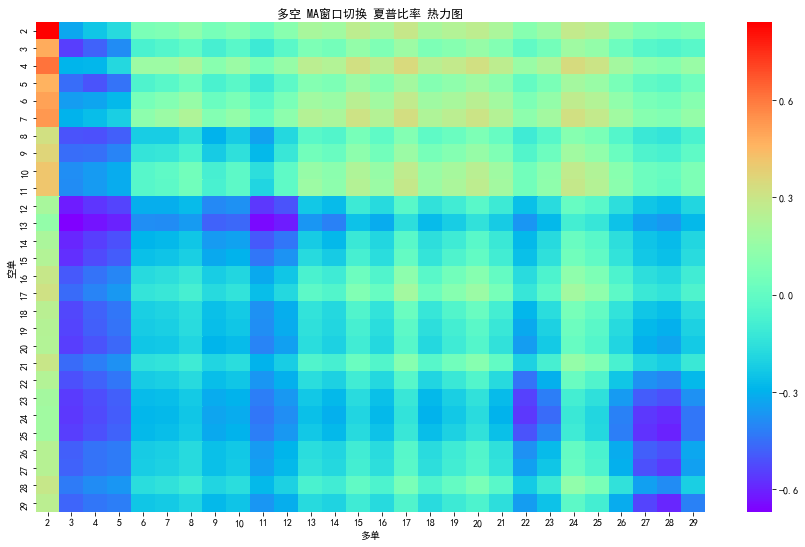

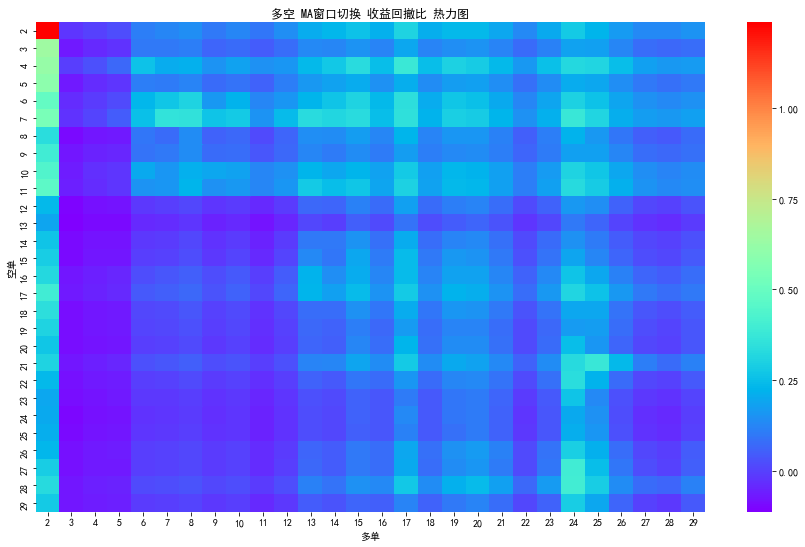

In [72]:
key_name={'WinProb':'胜率','SignalFreq':'信号频率','IR':'IR','sharpe_ratio':'夏普比率','return_max_drawdown_ratio':'收益回撤比',}
for key in LongShortMADict.keys():
    LongShortMADf=pd.DataFrame(LongShortMADict[key],dtype=np.float)
    plt.figure(figsize=(15,9))
    seaborn.heatmap(LongShortMADf,cmap='rainbow')
    plt.xlabel('多单')
    plt.ylabel('空单')
    plt.title('多空 MA窗口切换 %s 热力图'%(key_name[key]))
    plt.show()

## 策略12-2adj ∑B_t - ∑B_t-1 OR ∑B_t - ∑B'_t-1

In [103]:
# 构造有修正的T日持仓量top20-T-1日持仓量top20 - 修正方式：今有昨无，则用今表中增量值，今有昨有依然两者相减
# 多
LongDeltaDf = LongShortDeltaDf['持买单'].copy()
LongDeltaDf['昨多单持仓量'] = LongDeltaDf['多单持仓量'] - LongDeltaDf['多单持仓增量']
LongDeltaDf_SUMofComp = LongDeltaDf.groupby(['日期','合约名称']).sum().reset_index()

All_tradeday = LongDeltaDf_SUMofComp['日期'].unique()
L_DeltaV_List = []
L_Date_List = []
for dateCnt in range(1,len(All_tradeday)):
    last_date = All_tradeday[dateCnt-1]
    date = All_tradeday[dateCnt]

    LongDeltaDf_SUMofComp_last_date = LongDeltaDf_SUMofComp[LongDeltaDf_SUMofComp['日期'] == last_date]
    LongDeltaDf_SUMofComp_date = LongDeltaDf_SUMofComp[LongDeltaDf_SUMofComp['日期'] == date]

    last_date_cList = LongDeltaDf_SUMofComp_last_date['合约名称'].tolist()
    date_cList = LongDeltaDf_SUMofComp_date['合约名称'].tolist()

    DeltaV = 0
    for each_C in date_cList:
        if each_C in last_date_cList:
            DeltaV += LongDeltaDf_SUMofComp_date[LongDeltaDf_SUMofComp_date['合约名称'] == each_C]['多单持仓量'].tolist()[0] - LongDeltaDf_SUMofComp_last_date[LongDeltaDf_SUMofComp_last_date['合约名称'] == each_C]['多单持仓量'].tolist()[0]
        else:
            DeltaV += LongDeltaDf_SUMofComp_date[LongDeltaDf_SUMofComp_date['合约名称'] == each_C]['多单持仓增量'].tolist()[0]
    L_DeltaV_List.append(DeltaV)
    L_Date_List.append(date)

In [107]:
# 构造有修正的T日持仓量top20-T-1日持仓量top20 - 修正方式：今有昨无，则用今表中增量值，今有昨有依然两者相减
# 空
ShortDeltaDf = LongShortDeltaDf['持卖单'].copy()
ShortDeltaDf['昨空单持仓量'] = ShortDeltaDf['空单持仓量'] - ShortDeltaDf['空单持仓增量']
ShortDeltaDf_SUMofComp = ShortDeltaDf.groupby(['日期','合约名称']).sum().reset_index()

All_tradeday = ShortDeltaDf_SUMofComp['日期'].unique()
S_DeltaV_List = []
S_Date_List = []
for dateCnt in range(1,len(All_tradeday)):
    last_date = All_tradeday[dateCnt-1]
    date = All_tradeday[dateCnt]

    ShortDeltaDf_SUMofComp_last_date = ShortDeltaDf_SUMofComp[ShortDeltaDf_SUMofComp['日期'] == last_date]
    ShortDeltaDf_SUMofComp_date = ShortDeltaDf_SUMofComp[ShortDeltaDf_SUMofComp['日期'] == date]

    last_date_cList = ShortDeltaDf_SUMofComp_last_date['合约名称'].tolist()
    date_cList = ShortDeltaDf_SUMofComp_date['合约名称'].tolist()

    DeltaV = 0
    for each_C in date_cList:
        if each_C in last_date_cList:
            DeltaV += ShortDeltaDf_SUMofComp_date[ShortDeltaDf_SUMofComp_date['合约名称'] == each_C]['空单持仓量'].tolist()[0] - ShortDeltaDf_SUMofComp_last_date[ShortDeltaDf_SUMofComp_last_date['合约名称'] == each_C]['空单持仓量'].tolist()[0]
        else:
            DeltaV += ShortDeltaDf_SUMofComp_date[ShortDeltaDf_SUMofComp_date['合约名称'] == each_C]['空单持仓增量'].tolist()[0]
    S_DeltaV_List.append(DeltaV)
    S_Date_List.append(date)

In [115]:
LongDeltaV_adj = pd.DataFrame({'日期':L_Date_List,'多单持仓增量_adj':L_DeltaV_List}).set_index('日期')
ShortDeltaV_adj = pd.DataFrame({'日期':S_Date_List,'空单持仓增量_adj':S_DeltaV_List}).set_index('日期')
LongShortDeltaV_adj = pd.concat([LongDeltaV_adj,ShortDeltaV_adj],axis=1)

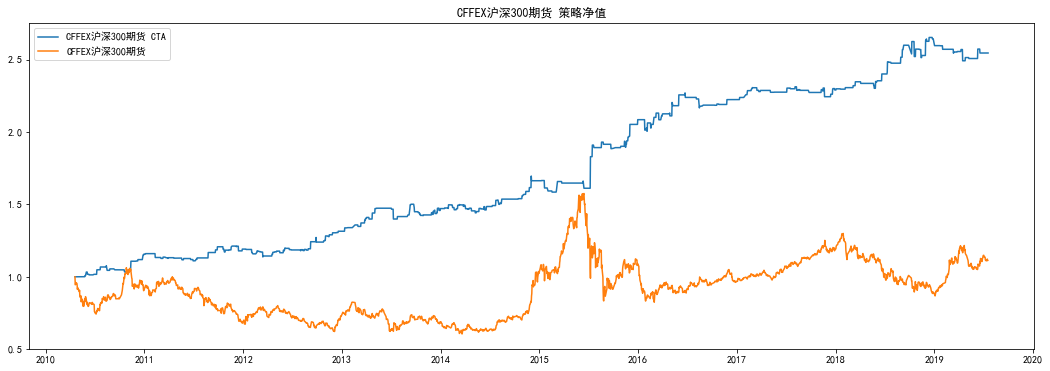

CFFEX沪深300期货胜率0.5820
CFFEX沪深300期货信号频率0.1383
CFFEX沪深300期货信号数量311
CFFEX沪深300期货正负信号比例0.9684
CFFEX沪深300期货信号IR值3.1253
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                        0.109116
vol_return                        0.0953379
IR                                  1.14452
sharpe_ratio                       0.829848
max_drawdown                      0.0653647
mean_return_max_drawdown_ratio      1.66934
max_drawdown_start               2014-12-02
max_drawdown_end                 2015-02-17
max_drawdown_last_Y                0.210815
------------------------------------------------------------------------


In [200]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
#         MALong, MAShort = 2,2
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = LongShortDeltaV_adj.copy()
#         SignalDataKIND['多单持仓量_DMA'] = SignalDataKIND['多单持仓量'] - SignalDataKIND['多单持仓量'].rolling(MALong).mean()
#         SignalDataKIND['空单持仓量_DMA'] = SignalDataKIND['空单持仓量'] - SignalDataKIND['空单持仓量'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓增量_adj']>0 and x['空单持仓增量_adj']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓增量_adj']<0 and x['空单持仓增量_adj']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break
    

In [143]:
SignalDataKIND[['Signal']].to_excel('C:/Users/Thinkpad/Desktop/表单回补调整策略_信号.xlsx')

In [141]:
EquitySeriesDfKIND.to_excel('C:/Users/Thinkpad/Desktop/S12-2adj.xlsx')

## 策略12-3 多空表：日期、公司、合约匹配 -> 取没匹配上的多空表剩余部分

In [121]:
LongShortDeltaDf_Outer = LongShortDeltaDf['持买单'].copy().merge(LongShortDeltaDf['持卖单'].copy(),on=['日期','合约名称','公司'],how='outer')

In [131]:
ShortDeltaDf_Outer = LongShortDeltaDf_Outer[np.isnan(LongShortDeltaDf_Outer['多单持仓量'])]
LongDeltaDf_Outer = LongShortDeltaDf_Outer[np.isnan(LongShortDeltaDf_Outer['空单持仓量'])]

In [133]:
LongDeltaDf_Outer_dV = LongDeltaDf_Outer.groupby(['日期']).sum()[['多单持仓增量']]
ShortDeltaDf_Outer_dV = ShortDeltaDf_Outer.groupby(['日期']).sum()[['空单持仓增量']]
LongShortDeltaDf_Outer_dV = pd.concat([LongDeltaDf_Outer_dV,ShortDeltaDf_Outer_dV],axis=1)

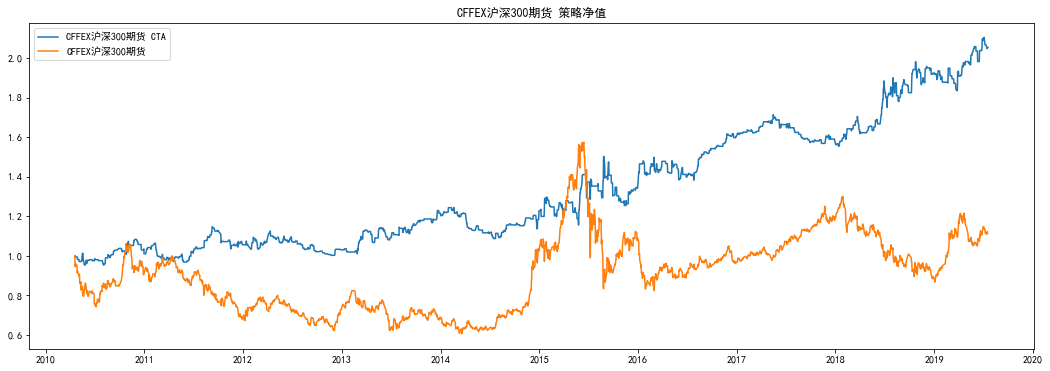

CFFEX沪深300期货胜率0.4949
CFFEX沪深300期货信号频率0.3459
CFFEX沪深300期货信号数量778
CFFEX沪深300期货正负信号比例1.1141
CFFEX沪深300期货信号IR值1.0583
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                       0.0913231
vol_return                         0.146897
IR                                 0.621682
sharpe_ratio                       0.417457
max_drawdown                       0.164703
mean_return_max_drawdown_ratio     0.554472
max_drawdown_start               2015-08-28
max_drawdown_end                 2015-11-12
max_drawdown_last_Y                0.208077
------------------------------------------------------------------------


In [199]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
#         MALong, MAShort = 2,2
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = LongShortDeltaDf_Outer_dV.copy()
#         SignalDataKIND['多单持仓量_DMA'] = SignalDataKIND['多单持仓量'] - SignalDataKIND['多单持仓量'].rolling(MALong).mean()
#         SignalDataKIND['空单持仓量_DMA'] = SignalDataKIND['空单持仓量'] - SignalDataKIND['空单持仓量'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

## 策略12-4 deltaB - deltaTolV, deltaS - deltaTolV

In [220]:
PositionVDf_DeltaV_LongShort = PositionVDf_DeltaV.groupby('日期').sum().merge(LongShortTolVandDV,left_index=True,right_index=True)

PositionVDf_DeltaV_LongShort['dB_dV'] = PositionVDf_DeltaV_LongShort['多单持仓增量'] - PositionVDf_DeltaV_LongShort['持仓量增量']
PositionVDf_DeltaV_LongShort['dS_dV'] = PositionVDf_DeltaV_LongShort['空单持仓增量'] - PositionVDf_DeltaV_LongShort['持仓量增量']

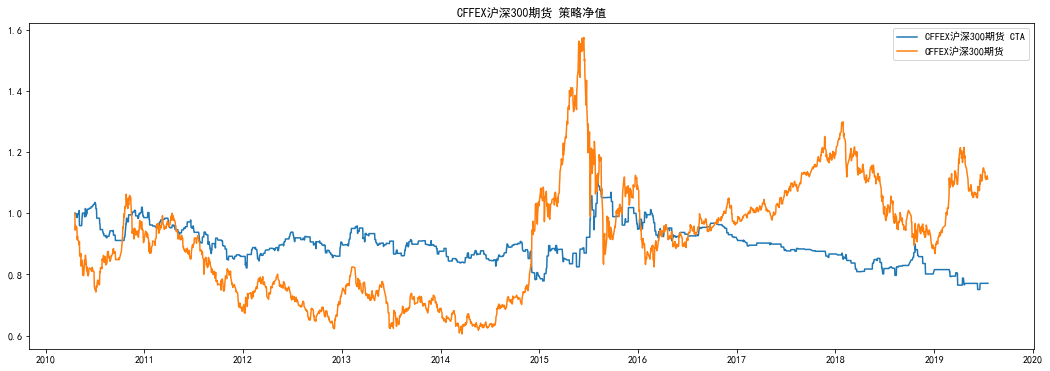

CFFEX沪深300期货胜率0.4936
CFFEX沪深300期货信号频率0.2423
CFFEX沪深300期货信号数量545
CFFEX沪深300期货正负信号比例0.8350
CFFEX沪深300期货信号IR值-0.3216
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                      -0.0206572
vol_return                         0.130423
IR                                -0.158386
sharpe_ratio                      -0.388408
max_drawdown                       0.329446
mean_return_max_drawdown_ratio   -0.0627028
max_drawdown_start               2015-08-06
max_drawdown_end                 2019-06-11
max_drawdown_last_Y                 3.84668
------------------------------------------------------------------------


In [250]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
#         MALong, MAShort = 2,2
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = PositionVDf_DeltaV_LongShort.copy()
#         SignalDataKIND['多单持仓量_DMA'] = SignalDataKIND['多单持仓量'] - SignalDataKIND['多单持仓量'].rolling(MALong).mean()
#         SignalDataKIND['空单持仓量_DMA'] = SignalDataKIND['空单持仓量'] - SignalDataKIND['空单持仓量'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['dB_dV']>0 and x['dS_dV']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['dB_dV']<0 and x['dS_dV']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

## 策略12-5 deltaB / deltaTolV, deltaS / deltaTolV

In [239]:
PositionVDf_DeltaV_LongShort = PositionVDf_DeltaV.groupby('日期').sum().merge(LongShortTolVandDV,left_index=True,right_index=True)

PositionVDf_DeltaV_LongShort['dB/dV'] = PositionVDf_DeltaV_LongShort['多单持仓增量'] / PositionVDf_DeltaV_LongShort['持仓量增量']
PositionVDf_DeltaV_LongShort['dS/dV'] = PositionVDf_DeltaV_LongShort['空单持仓增量'] / PositionVDf_DeltaV_LongShort['持仓量增量']

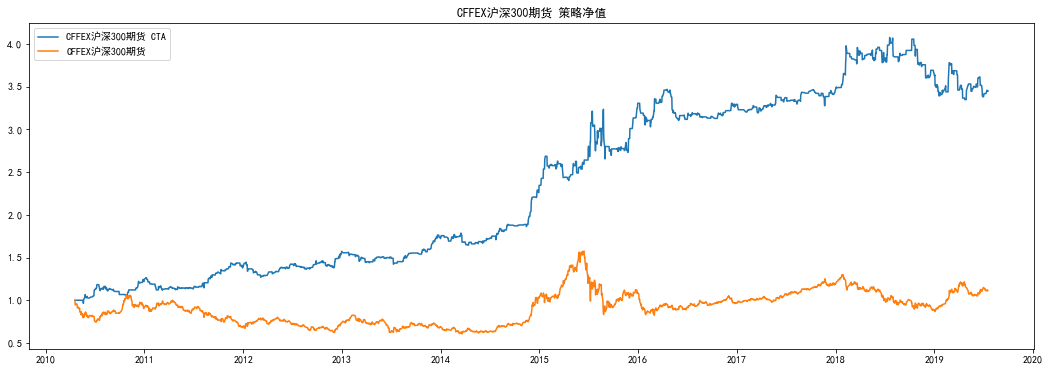

CFFEX沪深300期货胜率0.5574
CFFEX沪深300期货信号频率0.3944
CFFEX沪深300期货信号数量887
CFFEX沪深300期货正负信号比例0.9843
CFFEX沪深300期货信号IR值1.4882
多头窗口16 空头窗口4
                               CFFEX沪深300期货
mean_return                        0.152026
vol_return                         0.163075
IR                                 0.932246
sharpe_ratio                       0.748281
max_drawdown                       0.179446
mean_return_max_drawdown_ratio     0.847196
max_drawdown_start               2015-08-26
max_drawdown_end                 2015-09-01
max_drawdown_last_Y               0.0164271
------------------------------------------------------------------------


In [243]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
        MALong, MAShort = 16,4
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = PositionVDf_DeltaV_LongShort.copy()
        SignalDataKIND['dB/dV_DMA'] = SignalDataKIND['dB/dV'] - SignalDataKIND['dB/dV'].rolling(MALong).mean()
        SignalDataKIND['dS/dV_DMA'] = SignalDataKIND['dS/dV'] - SignalDataKIND['dS/dV'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['dB/dV_DMA']>0 and x['dS/dV_DMA']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['dB/dV_DMA']<0 and x['dS/dV_DMA']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

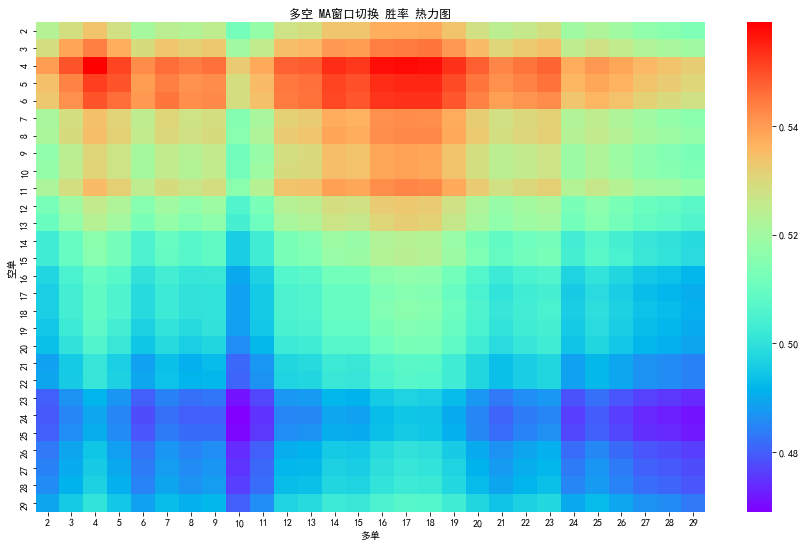

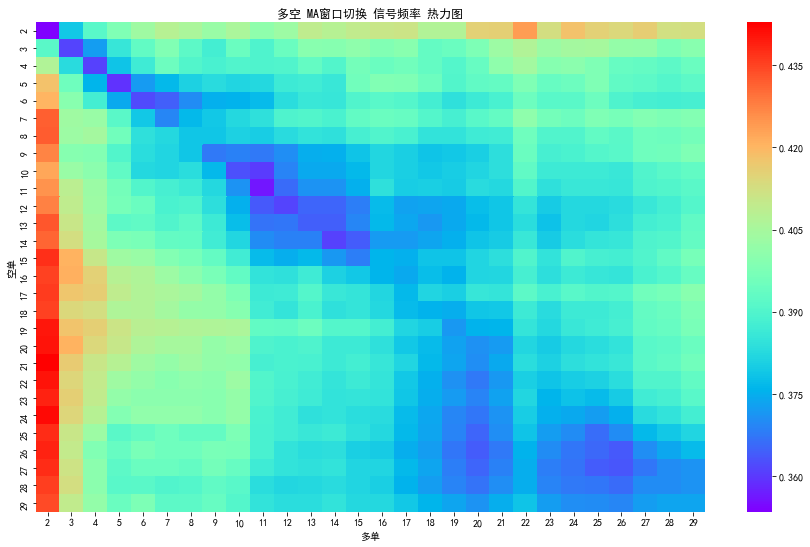

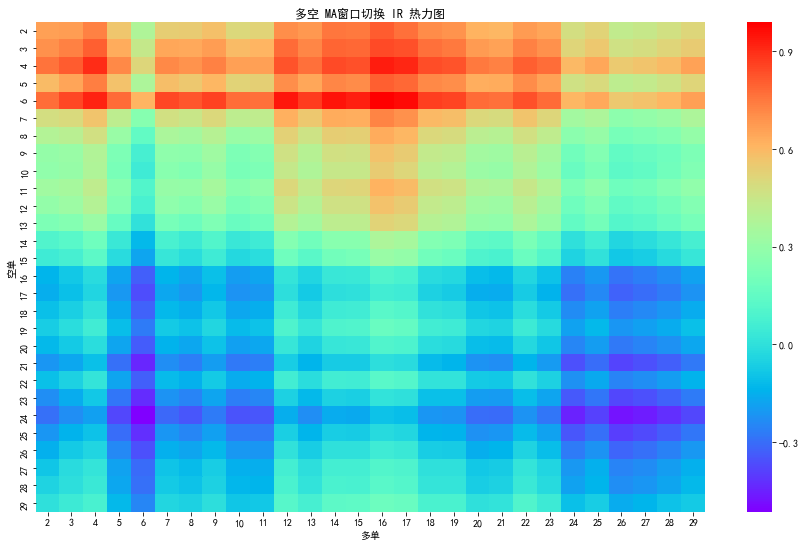

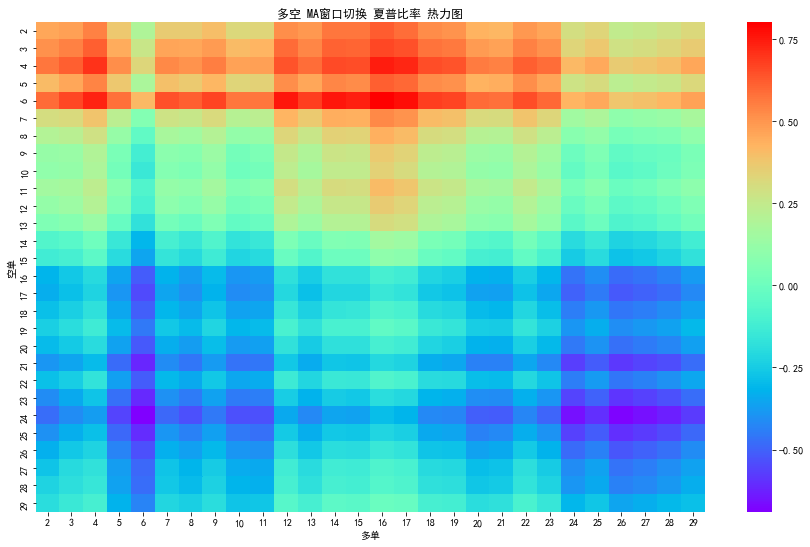

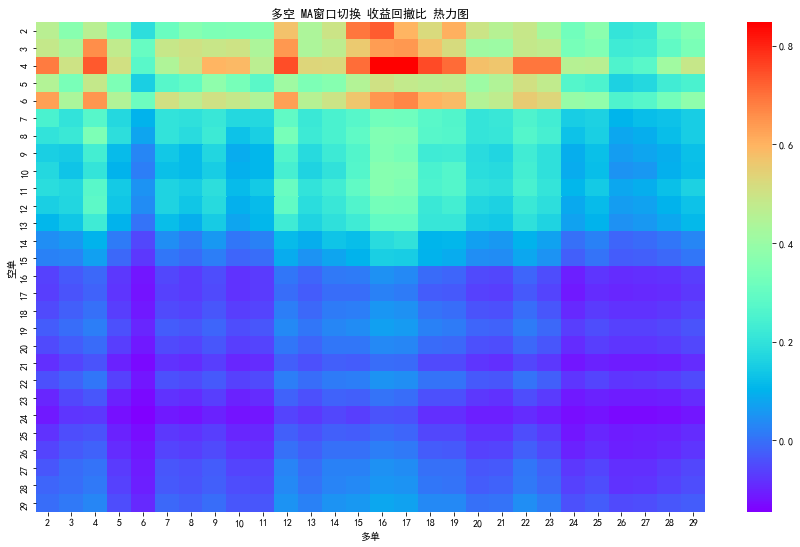

In [242]:
key_name={'WinProb':'胜率','SignalFreq':'信号频率','IR':'IR','sharpe_ratio':'夏普比率','return_max_drawdown_ratio':'收益回撤比',}
for key in LongShortMADict.keys():
    LongShortMADf=pd.DataFrame(LongShortMADict[key],dtype=np.float)
    plt.figure(figsize=(15,9))
    seaborn.heatmap(LongShortMADf,cmap='rainbow')
    plt.xlabel('多单')
    plt.ylabel('空单')
    plt.title('多空 MA窗口切换 %s 热力图'%(key_name[key]))
    plt.show()

## 策略12-6 含义不明 dB/dV、dS/dV Vs 0

In [ ]:
PositionVDf_DeltaV_LongShort = PositionVDf_DeltaV.groupby('日期').sum().merge(LongShortTolVandDV,left_index=True,right_index=True)

PositionVDf_DeltaV_LongShort['dB/dV'] = PositionVDf_DeltaV_LongShort['多单持仓增量'] / PositionVDf_DeltaV_LongShort['持仓量增量']
PositionVDf_DeltaV_LongShort['dS/dV'] = PositionVDf_DeltaV_LongShort['空单持仓增量'] / PositionVDf_DeltaV_LongShort['持仓量增量']

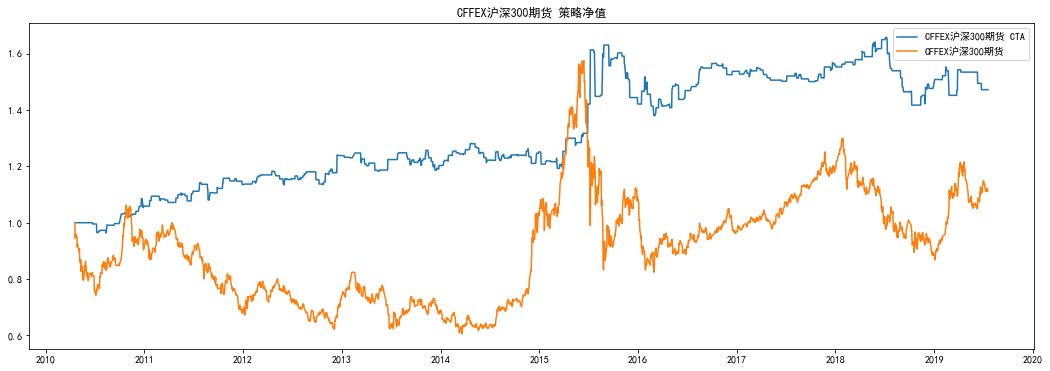

CFFEX沪深300期货胜率0.5169
CFFEX沪深300期货信号频率0.1574
CFFEX沪深300期货信号数量354
CFFEX沪深300期货正负信号比例0.8632
CFFEX沪深300期货信号IR值1.1045
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                        0.049648
vol_return                         0.113423
IR                                 0.437726
sharpe_ratio                       0.173228
max_drawdown                       0.153539
mean_return_max_drawdown_ratio     0.323357
max_drawdown_start               2015-09-15
max_drawdown_end                 2016-02-29
max_drawdown_last_Y                0.457221
------------------------------------------------------------------------


In [249]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

for MALong in MAList:
    for MAShort in MAList:
#         MALong, MAShort = 16,4
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = PositionVDf_DeltaV_LongShort.copy()
#         SignalDataKIND['dB/dV_DMA'] = SignalDataKIND['dB/dV'] - SignalDataKIND['dB/dV'].rolling(MALong).mean()
#         SignalDataKIND['dS/dV_DMA'] = SignalDataKIND['dS/dV'] - SignalDataKIND['dS/dV'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['dB/dV']<0 and x['dS/dV']>0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['dB/dV']>0 and x['dS/dV']<0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

# 策略13 主力合约

## 原始蜘蛛网

In [108]:
LongDeltaKIND_Ori = LongShortDelta[KIND]['持买单'].groupby(['日期']).sum()
ShortDeltaKIND_Ori = LongShortDelta[KIND]['持卖单'].groupby(['日期']).sum()

LongShortDeltaKIND_Ori = LongDeltaKIND_Ori.merge(ShortDeltaKIND_Ori,left_index=True,right_index=True)

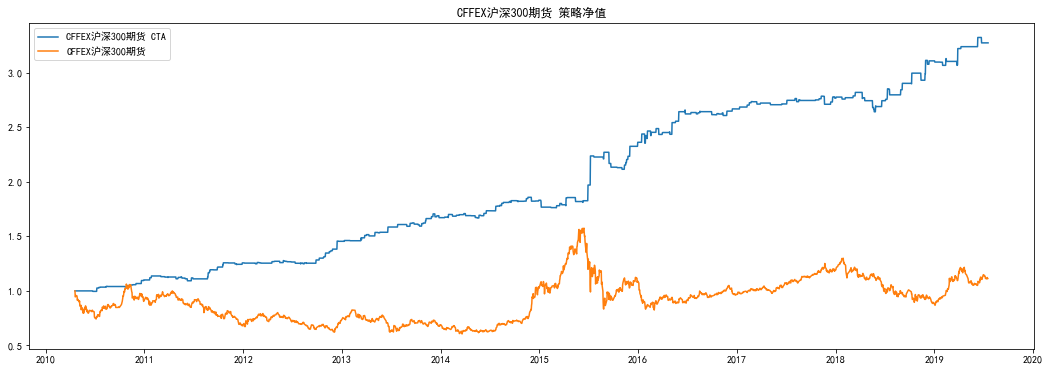

CFFEX沪深300期货胜率0.5730
CFFEX沪深300期货信号频率0.1218
CFFEX沪深300期货信号数量274
CFFEX沪深300期货正负信号比例1.2645
CFFEX沪深300期货信号IR值4.4201
多头窗口2 空头窗口2
                               CFFEX沪深300期货
mean_return                        0.212198
vol_return                         0.091608
IR                                  2.31637
sharpe_ratio                        1.98888
max_drawdown                      0.0686318
mean_return_max_drawdown_ratio      3.09183
max_drawdown_start               2015-09-15
max_drawdown_end                 2015-11-03
max_drawdown_last_Y                0.134155
------------------------------------------------------------------------


In [109]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = True

for MALong in MAList:
    for MAShort in MAList:
#         MALong, MAShort = 16,4
        KIND = KIND

        if KIND == 'CFFEX沪深300期货':
            start = '2010-04-19'
        else:
            start = '2015-04-20'
        end = '2019-07-19'

        ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
        PriceDataKIND = PriceData[[KIND]].dropna()
        iReturnDataKIND = iReturnData[[KIND]].dropna()
        ChangeDataKIND = ChangeData[[KIND]].dropna()

        ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
        PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
        iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

        '''
        主力合约更换信号计算：当天非零则下一天更换
        '''

        ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

        '''
        策略
        '''

        '''
        策略信号数据读取与计算
        '''

        SignalDataKIND = LongShortDeltaKIND_Ori.copy()
#         SignalDataKIND['dB/dV_DMA'] = SignalDataKIND['dB/dV'] - SignalDataKIND['dB/dV'].rolling(MALong).mean()
#         SignalDataKIND['dS/dV_DMA'] = SignalDataKIND['dS/dV'] - SignalDataKIND['dS/dV'].rolling(MAShort).mean()
        SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
        SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']
        
        if NextTrade == True:
            SignalDataKIND['日期'] = SignalDataKIND.index
            SignalDataKIND['NextIfTrade'] = (SignalDataKIND['日期'] - SignalDataKIND['日期'].shift(1)).shift(-1)
            SignalDataKIND['NextIfTrade'] = SignalDataKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
            SignalDataKIND['Signal'] = SignalDataKIND['Signal']*SignalDataKIND['NextIfTrade']

        SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


        '''
        结算数据匹配：T发出信号，匹配T+2开盘价收益
        '''

        EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

        '''
        更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
        '''

        ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
        EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
        EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

        '''
        结算
        '''

        EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
        EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
        benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

        plt.figure(figsize=(18,6))
        plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
        plt.plot(benchmarkEquity,label=KIND)
        plt.title(KIND+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 信号胜率计算
        Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
        WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
        # 信号数量计算
        SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
        SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
        # 信号比例计算
        SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
        SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
        SignalPosNegRatio = SignalPos/SignalNeg
        # 信号IR计算
        EquityDfKIND_IR = EquityDfKIND.dropna()
        EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
        EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
        IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

        print(KIND+'胜率%.4f' %(WinProb) )
        print(KIND+'信号频率%.4f' %(SignalFreq) )
        print(KIND+'信号数量%d' %(SignalNum) )
        print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
        print(KIND+'信号IR值%.4f' %(IR_signal))

        print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        print(IndicatorKIND[0])

        print('------------------------------------------------------------------------\r')

        LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
        LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
        IndicatorKIND = Indicator(EquitySeriesDfKIND)
        LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
        LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
        LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]
        
        break

        print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        
    break

### 原始蜘蛛网结果图↑

## 策略13-1 只看主力合约的蜘蛛网

In [110]:
ChangeDataKIND_ = ChangeData[[KIND]]
ChangeDataKIND_ = ChangeDataKIND_.reset_index().rename(columns={KIND:'合约名称','date':'日期'}).dropna()
ChangeDataKIND_['合约名称'] = ChangeDataKIND_['合约名称'].apply(lambda x: x[:-4])
LongDeltaKIND_MainC = LongShortDelta[KIND]['持买单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'])
ShortDeltaKIND_MainC = LongShortDelta[KIND]['持卖单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'])

LongShortDeltaKIND_MainC = ShortDeltaKIND_MainC.merge(LongDeltaKIND_MainC,on=['日期','合约名称']).set_index('日期')

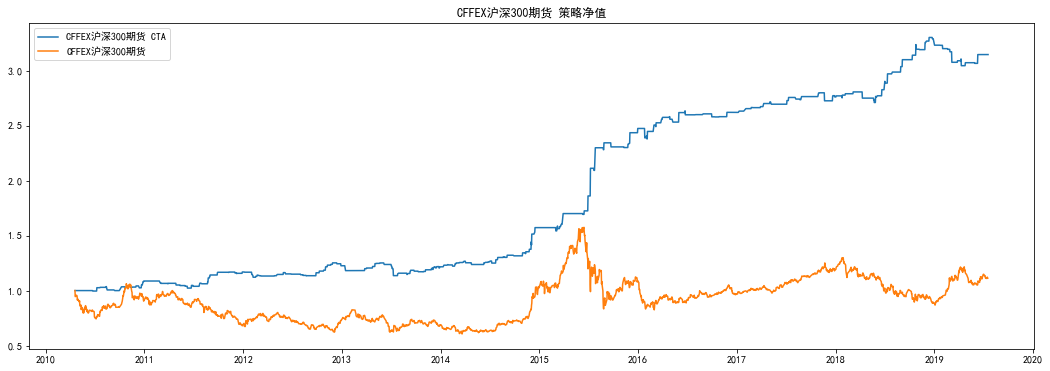

CFFEX沪深300期货胜率0.5960
CFFEX沪深300期货信号频率0.1112
CFFEX沪深300期货信号数量250
CFFEX沪深300期货正负信号比例1.5510
CFFEX沪深300期货信号IR值4.1505
仅看主力合约
                               CFFEX沪深300期货
mean_return                        0.204502
vol_return                        0.0989925
IR                                  2.06584
sharpe_ratio                        1.76278
max_drawdown                      0.0928063
mean_return_max_drawdown_ratio      2.20354
max_drawdown_start               2012-12-12
max_drawdown_end                 2013-07-10
max_drawdown_last_Y                0.574949
------------------------------------------------------------------------


In [111]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = False

KIND = KIND

if KIND == 'CFFEX沪深300期货':
    start = '2010-04-19'
else:
    start = '2015-04-20'
end = '2019-07-19'

ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
PriceDataKIND = PriceData[[KIND]].dropna()
iReturnDataKIND = iReturnData[[KIND]].dropna()
ChangeDataKIND = ChangeData[[KIND]].dropna()

ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

'''
主力合约更换信号计算：当天非零则下一天更换
'''

ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

'''
策略
'''

'''
策略信号数据读取与计算
'''

SignalDataKIND = LongShortDeltaKIND_MainC.copy()
# SignalDataKIND['dB/dV_DMA'] = SignalDataKIND['dB/dV'] - SignalDataKIND['dB/dV'].rolling(MALong).mean()
# SignalDataKIND['dS/dV_DMA'] = SignalDataKIND['dS/dV'] - SignalDataKIND['dS/dV'].rolling(MAShort).mean()
SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

if NextTrade == True:
    SignalDataKIND['日期'] = SignalDataKIND.index
    SignalDataKIND['NextIfTrade'] = (SignalDataKIND['日期'] - SignalDataKIND['日期'].shift(1)).shift(-1)
    SignalDataKIND['NextIfTrade'] = SignalDataKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
    SignalDataKIND['Signal'] = SignalDataKIND['Signal']*SignalDataKIND['NextIfTrade']

SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


'''
结算数据匹配：T发出信号，匹配T+2开盘价收益
'''

EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

'''
更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
'''

ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

'''
结算
'''

EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

plt.figure(figsize=(18,6))
plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
plt.plot(benchmarkEquity,label=KIND)
plt.title(KIND+' 策略净值')
plt.legend(loc=0)
plt.show()

# 信号胜率计算
Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
# 信号数量计算
SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
# 信号比例计算
SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
SignalPosNegRatio = SignalPos/SignalNeg
# 信号IR计算
EquityDfKIND_IR = EquityDfKIND.dropna()
EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

print(KIND+'胜率%.4f' %(WinProb) )
print(KIND+'信号频率%.4f' %(SignalFreq) )
print(KIND+'信号数量%d' %(SignalNum) )
print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
print(KIND+'信号IR值%.4f' %(IR_signal))

print('仅看主力合约')
IndicatorKIND = Indicator(EquitySeriesDfKIND)
print(IndicatorKIND[0])

print('------------------------------------------------------------------------\r')

LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
IndicatorKIND = Indicator(EquitySeriesDfKIND)
LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]

# print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')
        

## 策略13-2 只看非主力合约的蜘蛛网

In [40]:
ChangeDataKIND_ = ChangeData[[KIND]].copy()
ChangeDataKIND_['主力'] = 1
ChangeDataKIND_ = ChangeDataKIND_.reset_index().rename(columns={KIND:'合约名称','date':'日期'}).dropna()
ChangeDataKIND_['合约名称'] = ChangeDataKIND_['合约名称'].apply(lambda x: x[:-4])
LongDeltaKIND_MainC = LongShortDelta[KIND]['持买单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'],how='outer')
ShortDeltaKIND_MainC = LongShortDelta[KIND]['持卖单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'],how='outer')

# LongShortDeltaKIND_MainC = ShortDeltaKIND_MainC.merge(LongDeltaKIND_MainC,on=['日期','合约名称']).set_index('日期')

In [41]:
LongDeltaKIND_NotMainC = LongDeltaKIND_MainC[LongDeltaKIND_MainC['主力'] != 1].groupby(['日期']).sum()
ShortDeltaKIND_NotMainC = ShortDeltaKIND_MainC[ShortDeltaKIND_MainC['主力'] != 1].groupby(['日期']).sum()
LongShortDeltaKIND_NotMainC = pd.concat([LongDeltaKIND_NotMainC,ShortDeltaKIND_NotMainC],axis=1)

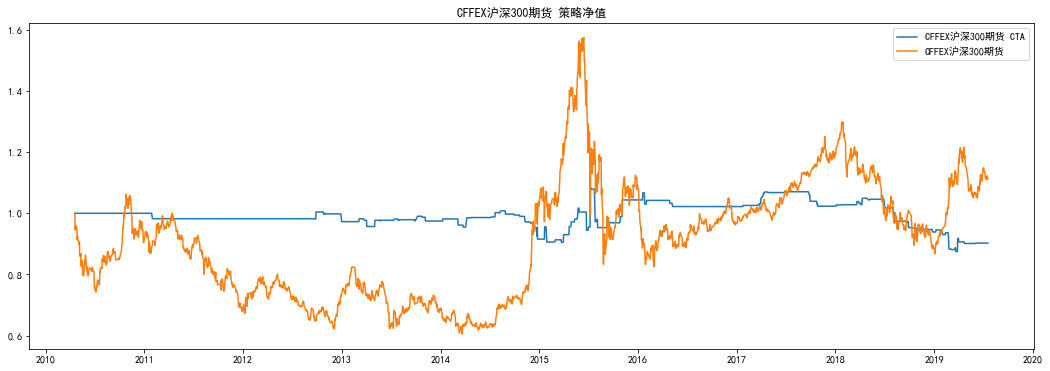

CFFEX沪深300期货胜率0.4793
CFFEX沪深300期货信号频率0.0778
CFFEX沪深300期货信号数量121
CFFEX沪深300期货正负信号比例1.5745
CFFEX沪深300期货信号IR值-0.3959
仅看非主力合约
                               CFFEX沪深300期货
mean_return                     -0.00787538
vol_return                          0.08547
IR                               -0.0921421
sharpe_ratio                      -0.443142
max_drawdown                        0.19299
mean_return_max_drawdown_ratio   -0.0408073
max_drawdown_start               2015-07-10
max_drawdown_end                 2019-03-22
max_drawdown_last_Y                 3.69884
------------------------------------------------------------------------


In [55]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = False

KIND = KIND

if KIND == 'CFFEX沪深300期货':
    start = '2010-04-19'
else:
    start = '2015-04-20'
end = '2019-07-19'

ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
PriceDataKIND = PriceData[[KIND]].dropna()
iReturnDataKIND = iReturnData[[KIND]].dropna()
ChangeDataKIND = ChangeData[[KIND]].dropna()

ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

'''
主力合约更换信号计算：当天非零则下一天更换
'''

ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

'''
策略
'''

'''
策略信号数据读取与计算
'''

SignalDataKIND = LongShortDeltaKIND_NotMainC.copy()
#         SignalDataKIND['dB/dV_DMA'] = SignalDataKIND['dB/dV'] - SignalDataKIND['dB/dV'].rolling(MALong).mean()
#         SignalDataKIND['dS/dV_DMA'] = SignalDataKIND['dS/dV'] - SignalDataKIND['dS/dV'].rolling(MAShort).mean()
SignalDataKIND['Signal_Long'] = SignalDataKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
SignalDataKIND['Signal_Short'] = SignalDataKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
SignalDataKIND['Signal'] = SignalDataKIND['Signal_Long']+SignalDataKIND['Signal_Short']

if NextTrade == True:
    SignalDataKIND['日期'] = SignalDataKIND.index
    SignalDataKIND['NextIfTrade'] = (SignalDataKIND['日期'] - SignalDataKIND['日期'].shift(1)).shift(-1)
    SignalDataKIND['NextIfTrade'] = SignalDataKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
    SignalDataKIND['Signal'] = SignalDataKIND['Signal']*SignalDataKIND['NextIfTrade']        

SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


'''
结算数据匹配：T发出信号，匹配T+2开盘价收益
'''

EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

'''
更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
'''

ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

'''
结算
'''

EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

plt.figure(figsize=(18,6))
plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
plt.plot(benchmarkEquity,label=KIND)
plt.title(KIND+' 策略净值')
plt.legend(loc=0)
plt.show()

# 信号胜率计算
Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
# 信号数量计算
SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
# 信号比例计算
SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
SignalPosNegRatio = SignalPos/SignalNeg
# 信号IR计算
EquityDfKIND_IR = EquityDfKIND.dropna()
EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

print(KIND+'胜率%.4f' %(WinProb) )
print(KIND+'信号频率%.4f' %(SignalFreq) )
print(KIND+'信号数量%d' %(SignalNum) )
print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
print(KIND+'信号IR值%.4f' %(IR_signal))

print('仅看非主力合约')
IndicatorKIND = Indicator(EquitySeriesDfKIND)
print(IndicatorKIND[0])

print('------------------------------------------------------------------------\r')

LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
IndicatorKIND = Indicator(EquitySeriesDfKIND)
LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]

## 策略13-3 原始蜘蛛网+参考主力合约信号

In [21]:
ChangeDataKIND_ = ChangeData[[KIND]]
ChangeDataKIND_ = ChangeDataKIND_.reset_index().rename(columns={KIND:'合约名称','date':'日期'}).dropna()
ChangeDataKIND_['合约名称'] = ChangeDataKIND_['合约名称'].apply(lambda x: x[:-4])
LongDeltaKIND_MainC = LongShortDelta[KIND]['持买单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'])
ShortDeltaKIND_MainC = LongShortDelta[KIND]['持卖单'].groupby(['日期','合约名称']).sum().merge(ChangeDataKIND_,on=['日期','合约名称'])

LongShortDeltaKIND_MainC = ShortDeltaKIND_MainC.merge(LongDeltaKIND_MainC,on=['日期','合约名称']).set_index('日期')

In [22]:
LongDeltaKIND = LongShortDelta[KIND]['持买单'].groupby(['日期']).sum()
ShortDeltaKIND = LongShortDelta[KIND]['持卖单'].groupby(['日期']).sum()
LongShortDeltaKIND = ShortDeltaKIND.merge(LongDeltaKIND,left_index=True,right_index=True)

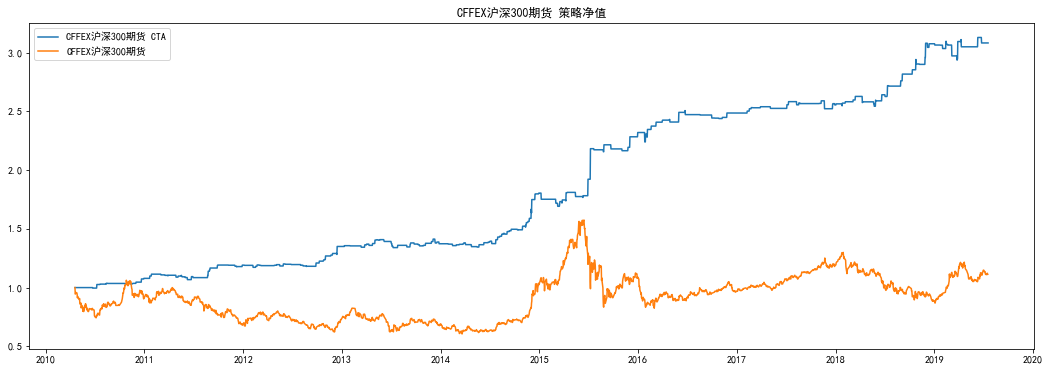

CFFEX沪深300期货胜率0.5709
CFFEX沪深300期货信号频率0.1129
CFFEX沪深300期货信号数量254
CFFEX沪深300期货正负信号比例3.8846
CFFEX沪深300期货信号IR值4.3103
多>0,空-2
                               CFFEX沪深300期货
mean_return                        0.130267
vol_return                        0.0926947
IR                                  1.40534
sharpe_ratio                        1.08169
max_drawdown                      0.0622149
mean_return_max_drawdown_ratio      2.09383
max_drawdown_start               2015-01-07
max_drawdown_end                 2015-03-10
max_drawdown_last_Y                0.169747
------------------------------------------------------------------------


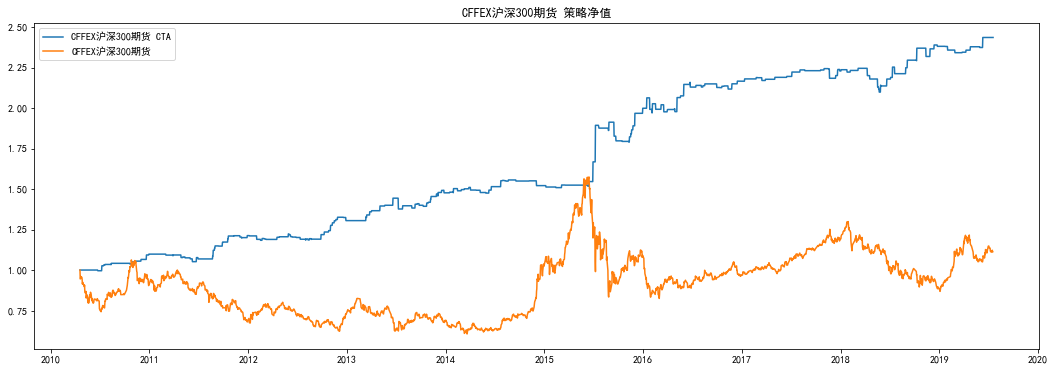

CFFEX沪深300期货胜率0.5747
CFFEX沪深300期货信号频率0.0983
CFFEX沪深300期货信号数量221
CFFEX沪深300期货正负信号比例0.5786
CFFEX沪深300期货信号IR值3.9866
多2,空<0
                               CFFEX沪深300期货
mean_return                        0.103252
vol_return                        0.0847946
IR                                  1.21767
sharpe_ratio                       0.863874
max_drawdown                      0.0654161
mean_return_max_drawdown_ratio      1.57839
max_drawdown_start               2018-04-09
max_drawdown_end                 2018-05-24
max_drawdown_last_Y                0.123203
------------------------------------------------------------------------


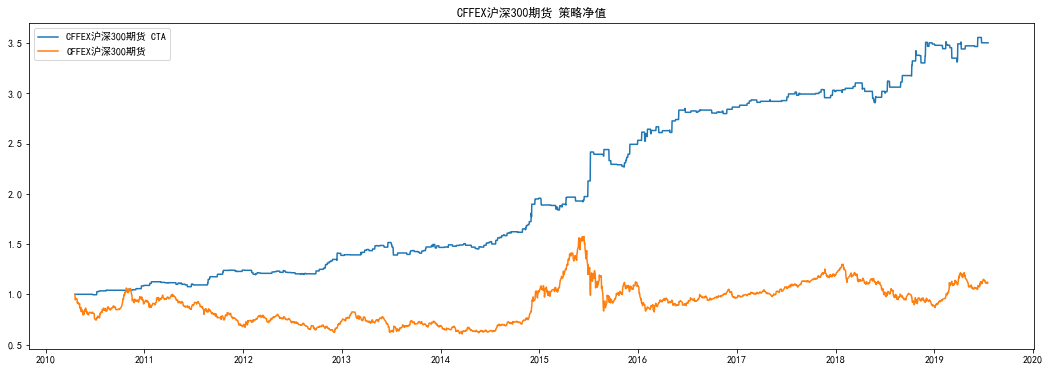

CFFEX沪深300期货胜率0.5614
CFFEX沪深300期货信号频率0.1521
CFFEX沪深300期货信号数量342
CFFEX沪深300期货正负信号比例1.4429
CFFEX沪深300期货信号IR值3.7346
多>0,空<0
                               CFFEX沪深300期货
mean_return                        0.145543
vol_return                         0.102158
IR                                  1.42468
sharpe_ratio                        1.13102
max_drawdown                      0.0821219
mean_return_max_drawdown_ratio      1.77228
max_drawdown_start               2013-07-01
max_drawdown_end                 2013-07-10
max_drawdown_last_Y               0.0246407
------------------------------------------------------------------------


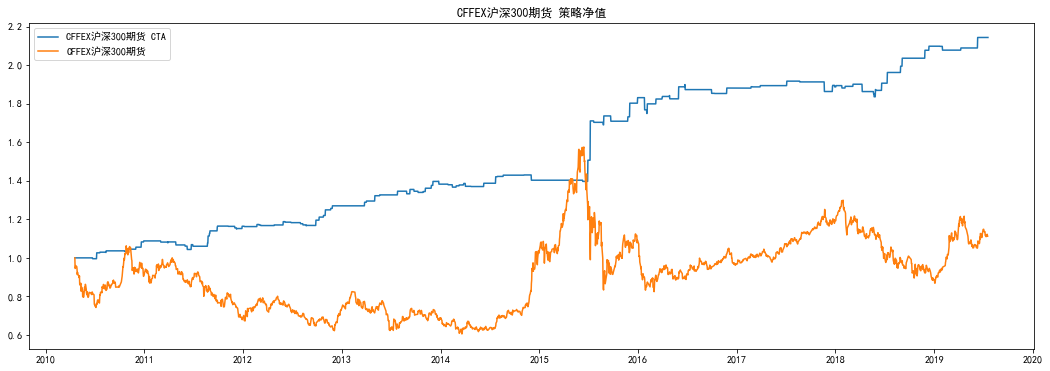

CFFEX沪深300期货胜率0.6015
CFFEX沪深300期货信号频率0.0591
CFFEX沪深300期货信号数量133
CFFEX沪深300期货正负信号比例1.5577
CFFEX沪深300期货信号IR值5.1764
多2,空-2
                               CFFEX沪深300期货
mean_return                       0.0879762
vol_return                        0.0730822
IR                                   1.2038
sharpe_ratio                       0.793301
max_drawdown                      0.0448063
mean_return_max_drawdown_ratio      1.96348
max_drawdown_start               2016-01-25
max_drawdown_end                 2016-02-03
max_drawdown_last_Y               0.0246407
------------------------------------------------------------------------


In [46]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = True

for Which in ['多>0,空-2','多2,空<0','多>0,空<0','多2,空-2']:
    KIND = KIND

    if KIND == 'CFFEX沪深300期货':
        start = '2010-04-19'
    else:
        start = '2015-04-20'
    end = '2019-07-19'

    ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
    PriceDataKIND = PriceData[[KIND]].dropna()
    iReturnDataKIND = iReturnData[[KIND]].dropna()
    ChangeDataKIND = ChangeData[[KIND]].dropna()

    ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
    PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
    iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

    '''
    主力合约更换信号计算：当天非零则下一天更换
    '''

    ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

    '''
    策略
    '''

    '''
    策略信号数据读取与计算
    '''

    SignalDataKIND1 = LongShortDeltaKIND_MainC.copy()
    SignalDataKIND1['Signal_Long'] = SignalDataKIND1.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataKIND1['Signal_Short'] = SignalDataKIND1.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataKIND1['Signal'] = SignalDataKIND1['Signal_Long']+SignalDataKIND1['Signal_Short']

    SignalDataKIND2 = LongShortDeltaKIND.copy()
    SignalDataKIND2['Signal_Long'] = SignalDataKIND2.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataKIND2['Signal_Short'] = SignalDataKIND2.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataKIND2['Signal'] = SignalDataKIND2['Signal_Long']+SignalDataKIND2['Signal_Short']

    if Which == '多>0,空-2':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x>0 else -1 if x==-2 else 0).to_frame()
    if Which == '多2,空<0':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x==2 else -1 if x<0 else 0).to_frame()
    if Which == '多>0,空<0':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0).to_frame()
    if Which == '多2,空-2':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x==2 else -1 if x==-2 else 0).to_frame()

    if NextTrade == True:
        SignalDataKIND['日期'] = SignalDataKIND.index
        SignalDataKIND['NextIfTrade'] = (SignalDataKIND['日期'] - SignalDataKIND['日期'].shift(1)).shift(-1)
        SignalDataKIND['NextIfTrade'] = SignalDataKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal']*SignalDataKIND['NextIfTrade']

    SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


    '''
    结算数据匹配：T发出信号，匹配T+2开盘价收益
    '''

    EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

    '''
    更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
    '''

    ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
    EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
    EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

    '''
    结算
    '''

    EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
    EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
    benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

    plt.figure(figsize=(18,6))
    plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
    plt.plot(benchmarkEquity,label=KIND)
    plt.title(KIND+' 策略净值')
    plt.legend(loc=0)
    plt.show()

    # 信号胜率计算
    Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
    WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
    # 信号数量计算
    SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
    SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
    # 信号比例计算
    SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
    SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
    SignalPosNegRatio = SignalPos/SignalNeg
    # 信号IR计算
    EquityDfKIND_IR = EquityDfKIND.dropna()
    EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
    EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
    IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

    print(KIND+'胜率%.4f' %(WinProb) )
    print(KIND+'信号频率%.4f' %(SignalFreq) )
    print(KIND+'信号数量%d' %(SignalNum) )
    print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
    print(KIND+'信号IR值%.4f' %(IR_signal))

    print(Which)
    IndicatorKIND = Indicator(EquitySeriesDfKIND)
    print(IndicatorKIND[0])

    print('------------------------------------------------------------------------\r')

    LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
    LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
    IndicatorKIND = Indicator(EquitySeriesDfKIND)
    LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
    LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
    LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]

    print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')

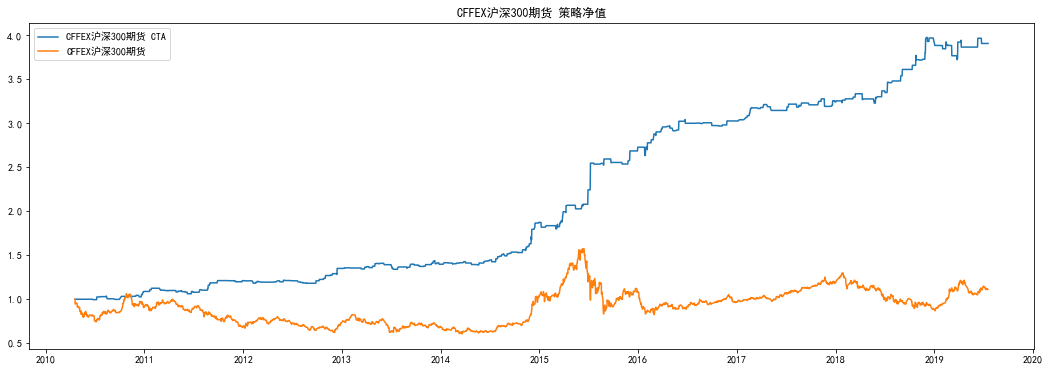

CFFEX沪深300期货胜率0.5903
CFFEX沪深300期货信号频率0.1378
CFFEX沪深300期货信号数量310
CFFEX沪深300期货正负信号比例3.4286
CFFEX沪深300期货信号IR值4.4265
多>0,空-2
                               CFFEX沪深300期货
mean_return                        0.157479
vol_return                        0.0988785
IR                                  1.59266
sharpe_ratio                        1.28925
max_drawdown                      0.0634141
mean_return_max_drawdown_ratio      2.48335
max_drawdown_start               2018-12-06
max_drawdown_end                 2019-03-26
max_drawdown_last_Y                0.301164
------------------------------------------------------------------------


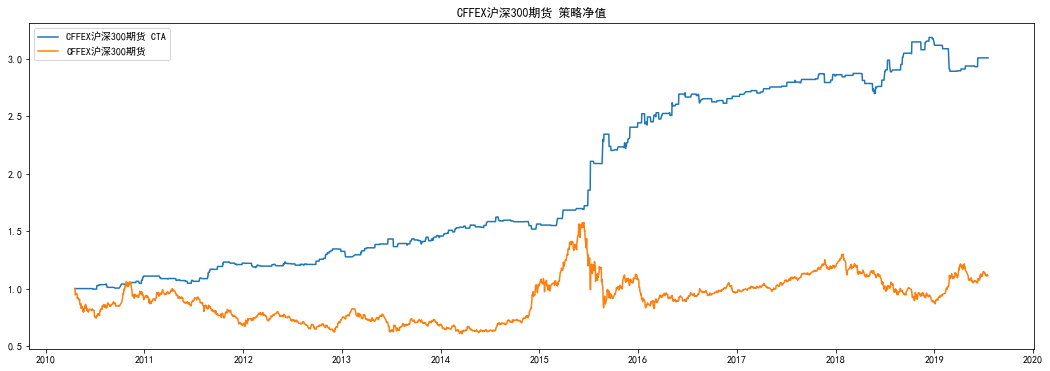

CFFEX沪深300期货胜率0.5788
CFFEX沪深300期货信号频率0.1298
CFFEX沪深300期货信号数量292
CFFEX沪深300期货正负信号比例0.4822
CFFEX沪深300期货信号IR值3.5291
多2,空<0
                               CFFEX沪深300期货
mean_return                        0.128557
vol_return                         0.103124
IR                                  1.24663
sharpe_ratio                       0.955718
max_drawdown                      0.0922955
mean_return_max_drawdown_ratio      1.39289
max_drawdown_start               2018-12-24
max_drawdown_end                 2019-02-28
max_drawdown_last_Y                0.180698
------------------------------------------------------------------------


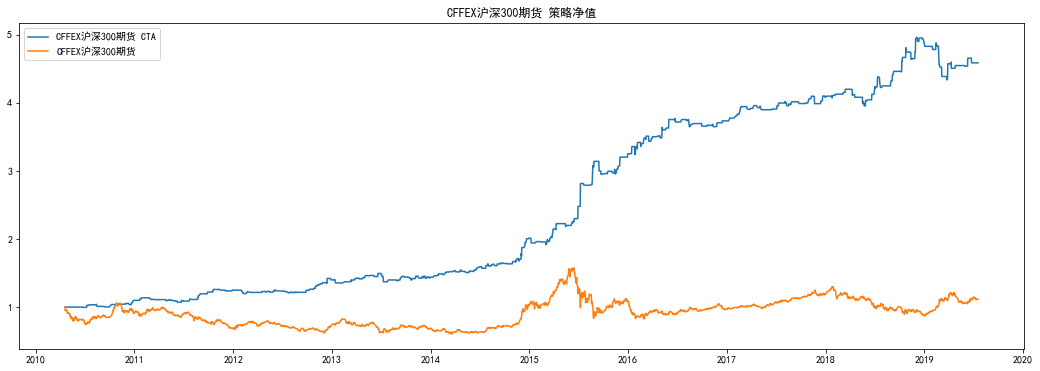

CFFEX沪深300期货胜率0.5744
CFFEX沪深300期货信号频率0.1943
CFFEX沪深300期货信号数量437
CFFEX沪深300期货正负信号比例1.2183
CFFEX沪深300期货信号IR值3.4595
多>0,空<0
                               CFFEX沪深300期货
mean_return                        0.177528
vol_return                         0.118542
IR                                   1.4976
sharpe_ratio                        1.24452
max_drawdown                       0.125898
mean_return_max_drawdown_ratio       1.4101
max_drawdown_start               2018-12-06
max_drawdown_end                 2019-03-26
max_drawdown_last_Y                0.301164
------------------------------------------------------------------------


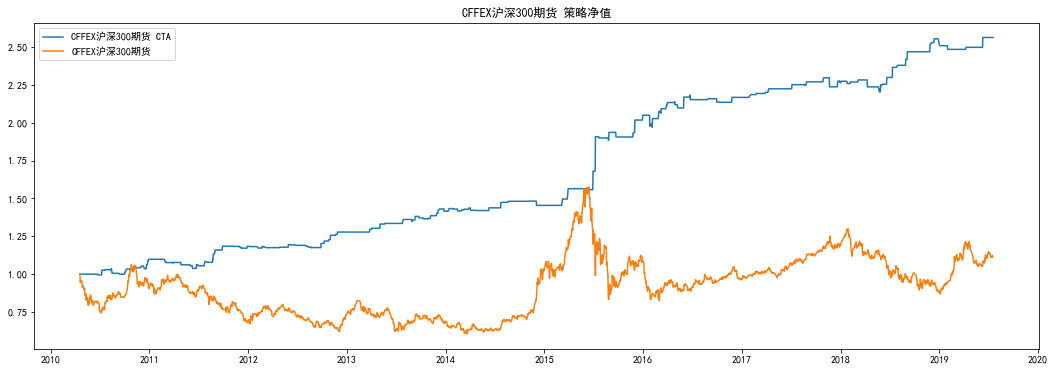

CFFEX沪深300期货胜率0.6121
CFFEX沪深300期货信号频率0.0734
CFFEX沪深300期货信号数量165
CFFEX沪深300期货正负信号比例1.3571
CFFEX沪深300期货信号IR值5.2644
多2,空-2
                               CFFEX沪深300期货
mean_return                        0.108509
vol_return                        0.0796962
IR                                  1.36153
sharpe_ratio                       0.985099
max_drawdown                      0.0546164
mean_return_max_drawdown_ratio      1.98674
max_drawdown_start               2011-02-25
max_drawdown_end                 2011-06-09
max_drawdown_last_Y                0.284736
------------------------------------------------------------------------


In [56]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
MAList = np.arange(2,30,1)

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = False

for Which in ['多>0,空-2','多2,空<0','多>0,空<0','多2,空-2']:
    KIND = KIND

    if KIND == 'CFFEX沪深300期货':
        start = '2010-04-19'
    else:
        start = '2015-04-20'
    end = '2019-07-19'

    ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
    PriceDataKIND = PriceData[[KIND]].dropna()
    iReturnDataKIND = iReturnData[[KIND]].dropna()
    ChangeDataKIND = ChangeData[[KIND]].dropna()

    ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
    PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
    iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

    '''
    主力合约更换信号计算：当天非零则下一天更换
    '''

    ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

    '''
    策略
    '''

    '''
    策略信号数据读取与计算
    '''

    SignalDataKIND1 = LongShortDeltaKIND_MainC.copy()
    SignalDataKIND1['Signal_Long'] = SignalDataKIND1.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataKIND1['Signal_Short'] = SignalDataKIND1.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataKIND1['Signal'] = SignalDataKIND1['Signal_Long']+SignalDataKIND1['Signal_Short']

    SignalDataKIND2 = LongShortDeltaKIND.copy()
    SignalDataKIND2['Signal_Long'] = SignalDataKIND2.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataKIND2['Signal_Short'] = SignalDataKIND2.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataKIND2['Signal'] = SignalDataKIND2['Signal_Long']+SignalDataKIND2['Signal_Short']

    if Which == '多>0,空-2':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x>0 else -1 if x==-2 else 0).to_frame()
    if Which == '多2,空<0':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x==2 else -1 if x<0 else 0).to_frame()
    if Which == '多>0,空<0':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0).to_frame()
    if Which == '多2,空-2':
        SignalDataKIND = (SignalDataKIND1 + SignalDataKIND2)['Signal'].apply(lambda x: 1 if x==2 else -1 if x==-2 else 0).to_frame()

    if NextTrade == True:
        SignalDataKIND['日期'] = SignalDataKIND.index
        SignalDataKIND['NextIfTrade'] = (SignalDataKIND['日期'] - SignalDataKIND['日期'].shift(1)).shift(-1)
        SignalDataKIND['NextIfTrade'] = SignalDataKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
        SignalDataKIND['Signal'] = SignalDataKIND['Signal']*SignalDataKIND['NextIfTrade']

    SignalDataKIND = SignalDataKIND[(SignalDataKIND.index>=start) & (SignalDataKIND.index<=end)]


    '''
    结算数据匹配：T发出信号，匹配T+2开盘价收益
    '''

    EquityDfKIND = SignalDataKIND.shift(1)[['Signal']].merge(ReturnDataKIND.shift(-1),left_index=True,right_index=True,how='right')

    '''
    更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
    '''

    ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
    EquityDfKIND = EquityDfKIND.merge(ChangeDfKIND,left_index=True,right_index=True).copy()
    EquityDfKIND[KIND] = EquityDfKIND.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)

    '''
    结算
    '''

    EquityDfKIND[KIND+'_equity'] = (EquityDfKIND['Signal']*EquityDfKIND[KIND]+1).fillna(1)
    EquitySeriesDfKIND = EquityDfKIND[[KIND+'_equity']].cumprod()
    benchmarkEquity = PriceDataKIND[KIND][:-1]/PriceDataKIND[KIND].tolist()[0]

    plt.figure(figsize=(18,6))
    plt.plot(EquitySeriesDfKIND,label=KIND+' CTA')
    plt.plot(benchmarkEquity,label=KIND)
    plt.title(KIND+' 策略净值')
    plt.legend(loc=0)
    plt.show()

    # 信号胜率计算
    Win = EquitySeriesDfKIND.pct_change().merge(EquityDfKIND[['Signal']],left_index=True,right_index=True).dropna()
    WinProb = Win[Win['Signal'] != 0][KIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
    # 信号数量计算
    SignalNum = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
    SignalFreq = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfKIND.dropna())
    # 信号比例计算
    SignalPos = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
    SignalNeg = EquityDfKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
    SignalPosNegRatio = SignalPos/SignalNeg
    # 信号IR计算
    EquityDfKIND_IR = EquityDfKIND.dropna()
    EquityDfKIND_IR = EquityDfKIND_IR[EquityDfKIND_IR['Signal'] != 0].copy()
    EquityDfKIND_IR['return'] = EquityDfKIND_IR['Signal']*EquityDfKIND_IR[KIND]
    IR_signal = EquityDfKIND_IR['return'].mean()/EquityDfKIND_IR['return'].std()*(252**0.5)

    print(KIND+'胜率%.4f' %(WinProb) )
    print(KIND+'信号频率%.4f' %(SignalFreq) )
    print(KIND+'信号数量%d' %(SignalNum) )
    print(KIND+'正负信号比例%.4f' %(SignalPosNegRatio))
    print(KIND+'信号IR值%.4f' %(IR_signal))

    print(Which)
    IndicatorKIND = Indicator(EquitySeriesDfKIND)
    print(IndicatorKIND[0])

    print('------------------------------------------------------------------------\r')

    LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
    LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
    IndicatorKIND = Indicator(EquitySeriesDfKIND)
    LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorKIND[0].loc['IR'][0]
    LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['sharpe_ratio'][0]
    LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorKIND[0].loc['mean_return_max_drawdown_ratio'][0]

    print('LongBetaMA:%.2f ShortBetaMA:%.2f' %((MALong-MAList[0])/len(MAList),(MAShort-MAList[0])/len(MAList)),end='\r')

# 策略14 主力合约 - 中证500 & 上证50

## 原始蜘蛛网策略

In [69]:
LongShortDelta_OtherKIND = {}
KINDList_OtherKIND = ['CFFEX中证500期货','CFFEX上证50期货']

nameChangeDict = {'持买单':'多单持仓增量','持卖单':'空单持仓增量','成交':'成交量增量'}
nameChangeDict_ = {'持买单':'多单持仓量','持卖单':'空单持仓量','成交':'成交量'}

for KIND in KINDList_OtherKIND:
    LongShortDeltaDf_OtherKIND = {}
    for LongOrShortOrV in ['持买单','持卖单','成交']:
        DfDeltaV = pd.read_excel('C:/Users/Thinkpad/Desktop/'+KIND_DICT[KIND]+LongOrShortOrV+'量排名蜘蛛网策略数据更新至20190722.xlsx')
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '华泰期货' if x == '华泰长城' else x)
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '五矿经易' if x == '五矿期货' else x)
        DfDeltaV['日期'] = DfDeltaV['日期'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d'))

        DfDeltaV = DfDeltaV.rename(columns={'变化量':nameChangeDict[LongOrShortOrV],
                                           '量':nameChangeDict_[LongOrShortOrV]})[['日期','公司','合约名称',nameChangeDict[LongOrShortOrV],nameChangeDict_[LongOrShortOrV]]]
        LongShortDeltaDf_OtherKIND[LongOrShortOrV] = DfDeltaV
            
    LongShortDelta_OtherKIND[KIND] = LongShortDeltaDf_OtherKIND

In [88]:
LongShortV_OtherKIND = {}
for OtherKIND in KINDList_OtherKIND:
    LongDeltaKIND_Ori = LongShortDelta_OtherKIND[OtherKIND]['持买单'].groupby(['日期']).sum()
    ShortDeltaKIND_Ori = LongShortDelta_OtherKIND[OtherKIND]['持卖单'].groupby(['日期']).sum()
    LongShortDeltaKIND_Ori = LongDeltaKIND_Ori.merge(ShortDeltaKIND_Ori,left_index=True,right_index=True)
    LongShortV_OtherKIND[OtherKIND] = LongShortDeltaKIND_Ori

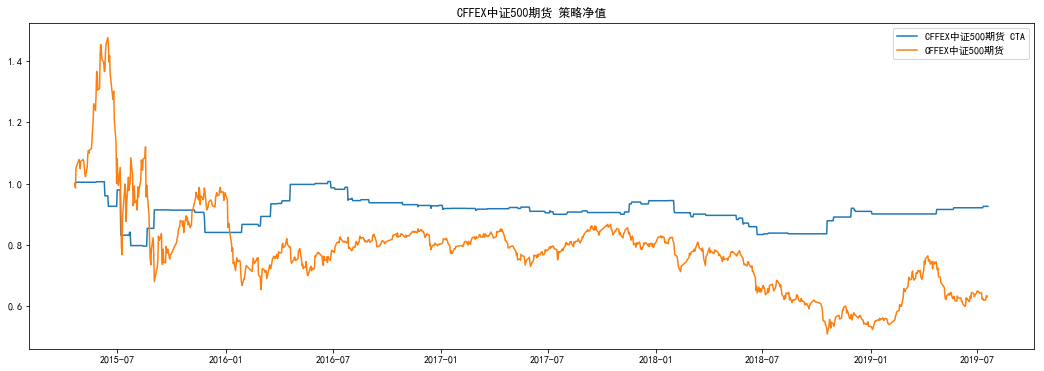

CFFEX中证500期货胜率0.5326
CFFEX中证500期货信号频率0.0887
CFFEX中证500期货信号数量92
CFFEX中证500期货正负信号比例1.5556
CFFEX中证500期货信号IR值-0.2728
多头窗口2 空头窗口2
                               CFFEX上证50期货
mean_return                     -0.0104038
vol_return                        0.127461
IR                              -0.0816236
sharpe_ratio                      -0.31699
max_drawdown                      0.209051
mean_return_max_drawdown_ratio   -0.049767
max_drawdown_start              2015-06-09
max_drawdown_end                2015-08-14
max_drawdown_last_Y               0.180698
------------------------------------------------------------------------


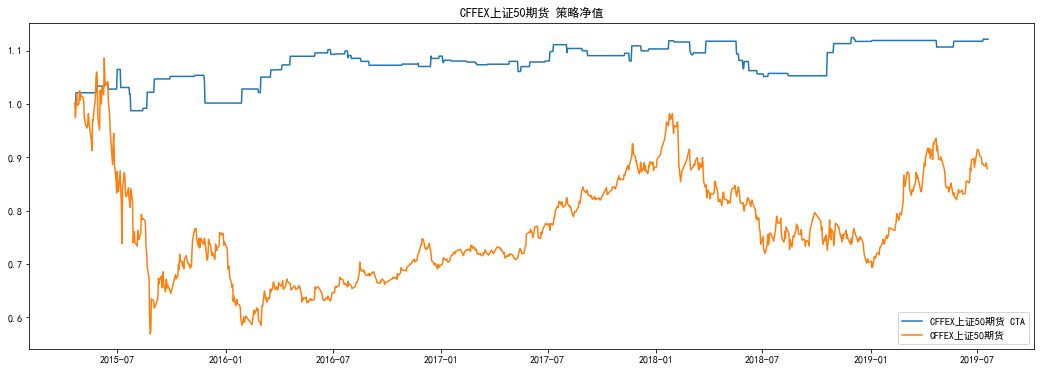

CFFEX上证50期货胜率0.5435
CFFEX上证50期货信号频率0.0887
CFFEX上证50期货信号数量92
CFFEX上证50期货正负信号比例1.5556
CFFEX上证50期货信号IR值1.5646
多头窗口2 空头窗口2
                               CFFEX上证50期货
mean_return                      0.0299084
vol_return                       0.0641767
IR                                0.466032
sharpe_ratio                   -0.00142753
max_drawdown                     0.0727255
mean_return_max_drawdown_ratio     0.41125
max_drawdown_start              2015-07-06
max_drawdown_end                2015-07-24
max_drawdown_last_Y              0.0492813
------------------------------------------------------------------------


In [83]:
otherKINDList_otherKIND = ['CFFEX中证500期货','CFFEX上证50期货']
otherKIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = True

for otherKIND in otherKINDList_otherKIND:
    otherKIND = otherKIND

    start = '2015-04-20'
    end = '2019-07-19'

    ReturnDataotherKIND = PriceData[[otherKIND]].dropna().pct_change().dropna()
    PriceDataotherKIND = PriceData[[otherKIND]].dropna()
    iReturnDataotherKIND = iReturnData[[otherKIND]].dropna()
    ChangeDataotherKIND = ChangeData[[otherKIND]].dropna()

    
    ReturnDataotherKIND = ReturnDataotherKIND[(ReturnDataotherKIND.index>=start) & (ReturnDataotherKIND.index<=end)]
    PriceDataotherKIND = PriceDataotherKIND[(PriceDataotherKIND.index>=start) & (PriceDataotherKIND.index<=end)]
    iReturnDataotherKIND = iReturnDataotherKIND[(iReturnDataotherKIND.index>=start) & (iReturnDataotherKIND.index<=end)]

    '''
    主力合约更换信号计算：当天非零则下一天更换
    '''

    ChangeDataotherKIND = ChangeDataotherKIND.merge(ChangeDataotherKIND.reset_index().groupby(otherKIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={otherKIND+'_y':otherKIND+'ChangeSig'})[[otherKIND+'ChangeSig']].fillna(0)

    '''
    策略
    '''

    '''
    策略信号数据读取与计算
    '''
    LongShortDeltaotherKIND_Ori = LongShortV_OtherKIND[OtherKIND]
    SignalDataotherKIND = LongShortDeltaotherKIND_Ori.copy()
#         SignalDataotherKIND['dB/dV_DMA'] = SignalDataotherKIND['dB/dV'] - SignalDataotherKIND['dB/dV'].rolling(MALong).mean()
#         SignalDataotherKIND['dS/dV_DMA'] = SignalDataotherKIND['dS/dV'] - SignalDataotherKIND['dS/dV'].rolling(MAShort).mean()
    SignalDataotherKIND['Signal_Long'] = SignalDataotherKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataotherKIND['Signal_Short'] = SignalDataotherKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataotherKIND['Signal'] = SignalDataotherKIND['Signal_Long']+SignalDataotherKIND['Signal_Short']

    if NextTrade == True:
        SignalDataotherKIND['日期'] = SignalDataotherKIND.index
        SignalDataotherKIND['NextIfTrade'] = (SignalDataotherKIND['日期'] - SignalDataotherKIND['日期'].shift(1)).shift(-1)
        SignalDataotherKIND['NextIfTrade'] = SignalDataotherKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
        SignalDataotherKIND['Signal'] = SignalDataotherKIND['Signal']*SignalDataotherKIND['NextIfTrade']

    SignalDataotherKIND = SignalDataotherKIND[(SignalDataotherKIND.index>=start) & (SignalDataotherKIND.index<=end)]


    '''
    结算数据匹配：T发出信号，匹配T+2开盘价收益
    '''

    EquityDfotherKIND = SignalDataotherKIND.shift(1)[['Signal']].merge(ReturnDataotherKIND.shift(-1),left_index=True,right_index=True,how='right')

    '''
    更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
    '''

    ChangeDfotherKIND = iReturnDataotherKIND.rename(columns={otherKIND:otherKIND+'Change'}).merge(ChangeDataotherKIND,left_index=True,right_index=True)
    EquityDfotherKIND = EquityDfotherKIND.merge(ChangeDfotherKIND,left_index=True,right_index=True).copy()
    EquityDfotherKIND[otherKIND] = EquityDfotherKIND.apply(lambda x: x[otherKIND+'Change'] if x[otherKIND+'ChangeSig'] != 0 else x[otherKIND],axis=1)

    '''
    结算
    '''

    EquityDfotherKIND[otherKIND+'_equity'] = (EquityDfotherKIND['Signal']*EquityDfotherKIND[otherKIND]+1).fillna(1)
    EquitySeriesDfotherKIND = EquityDfotherKIND[[otherKIND+'_equity']].cumprod()
    benchmarkEquity = PriceDataotherKIND[otherKIND][:-1]/PriceDataotherKIND[otherKIND].tolist()[0]

    plt.figure(figsize=(18,6))
    plt.plot(EquitySeriesDfotherKIND,label=otherKIND+' CTA')
    plt.plot(benchmarkEquity,label=otherKIND)
    plt.title(otherKIND+' 策略净值')
    plt.legend(loc=0)
    plt.show()

    # 信号胜率计算
    Win = EquitySeriesDfotherKIND.pct_change().merge(EquityDfotherKIND[['Signal']],left_index=True,right_index=True).dropna()
    WinProb = Win[Win['Signal'] != 0][otherKIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
    # 信号数量计算
    SignalNum = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
    SignalFreq = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfotherKIND.dropna())
    # 信号比例计算
    SignalPos = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
    SignalNeg = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
    SignalPosNegRatio = SignalPos/SignalNeg
    # 信号IR计算
    EquityDfotherKIND_IR = EquityDfotherKIND.dropna()
    EquityDfotherKIND_IR = EquityDfotherKIND_IR[EquityDfotherKIND_IR['Signal'] != 0].copy()
    EquityDfotherKIND_IR['return'] = EquityDfotherKIND_IR['Signal']*EquityDfotherKIND_IR[otherKIND]
    IR_signal = EquityDfotherKIND_IR['return'].mean()/EquityDfotherKIND_IR['return'].std()*(252**0.5)

    print(otherKIND+'胜率%.4f' %(WinProb) )
    print(otherKIND+'信号频率%.4f' %(SignalFreq) )
    print(otherKIND+'信号数量%d' %(SignalNum) )
    print(otherKIND+'正负信号比例%.4f' %(SignalPosNegRatio))
    print(otherKIND+'信号IR值%.4f' %(IR_signal))

    print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
    IndicatorotherKIND = Indicator(EquitySeriesDfotherKIND)
    print(IndicatorotherKIND[0])

    print('------------------------------------------------------------------------\r')

#     LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
#     LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
#     IndicatorotherKIND = Indicator(EquitySeriesDfotherKIND)
#     LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['IR'][0]
#     LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['sharpe_ratio'][0]
#     LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['mean_return_max_drawdown_ratio'][0]

## 策略14-1 只看主力合约的蜘蛛网

In [90]:
LongShortDeltaotherKIND_MainC_Dict = {}
for otherKIND in KINDList_OtherKIND:
    ChangeDataotherKIND_ = ChangeData[[otherKIND]]
    ChangeDataotherKIND_ = ChangeDataotherKIND_.reset_index().rename(columns={otherKIND:'合约名称','date':'日期'}).dropna()
    ChangeDataotherKIND_['合约名称'] = ChangeDataotherKIND_['合约名称'].apply(lambda x: x[:-4])
    LongDeltaotherKIND_MainC = LongShortDelta_OtherKIND[otherKIND]['持买单'].groupby(['日期','合约名称']).sum().merge(ChangeDataotherKIND_,on=['日期','合约名称'])
    ShortDeltaotherKIND_MainC = LongShortDelta_OtherKIND[otherKIND]['持卖单'].groupby(['日期','合约名称']).sum().merge(ChangeDataotherKIND_,on=['日期','合约名称'])

    LongShortDeltaotherKIND_MainC = ShortDeltaotherKIND_MainC.merge(LongDeltaotherKIND_MainC,on=['日期','合约名称']).set_index('日期')
    LongShortDeltaotherKIND_MainC_Dict[otherKIND] = LongShortDeltaotherKIND_MainC

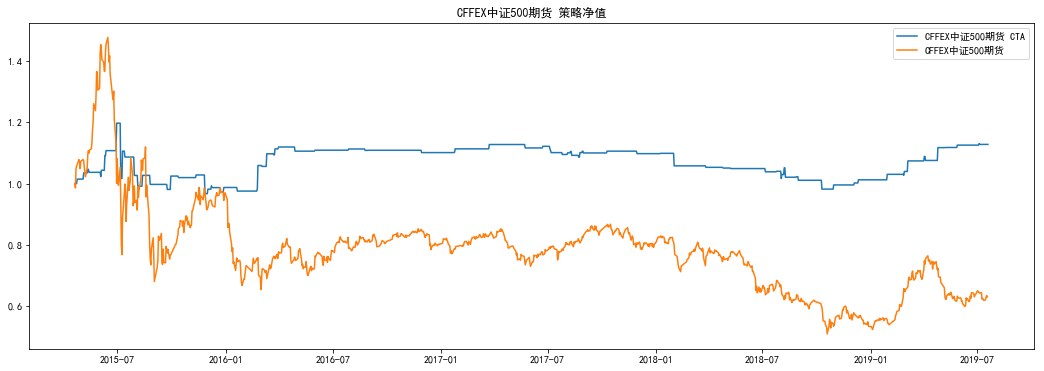

CFFEX中证500期货胜率0.5444
CFFEX中证500期货信号频率0.0870
CFFEX中证500期货信号数量90
CFFEX中证500期货正负信号比例1.3077
CFFEX中证500期货信号IR值0.9776
多头窗口2 空头窗口2
                               CFFEX上证50期货
mean_return                      0.0381002
vol_return                        0.131912
IR                                 0.28883
sharpe_ratio                     0.0614059
max_drawdown                       0.19216
mean_return_max_drawdown_ratio    0.198273
max_drawdown_start              2015-07-06
max_drawdown_end                2015-11-27
max_drawdown_last_Y               0.394251
------------------------------------------------------------------------


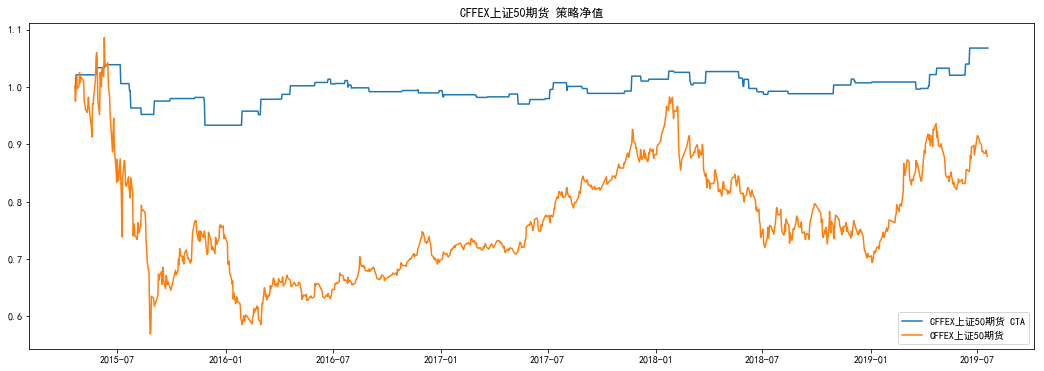

CFFEX上证50期货胜率0.5698
CFFEX上证50期货信号频率0.0836
CFFEX上证50期货信号数量86
CFFEX上证50期货正负信号比例1.8667
CFFEX上证50期货信号IR值1.0625
多头窗口2 空头窗口2
                               CFFEX上证50期货
mean_return                      0.0175693
vol_return                       0.0572568
IR                                0.306851
sharpe_ratio                     -0.217105
max_drawdown                      0.101658
mean_return_max_drawdown_ratio    0.172828
max_drawdown_start              2015-07-06
max_drawdown_end                2015-11-27
max_drawdown_last_Y               0.394251
------------------------------------------------------------------------


In [95]:
otherKINDList_otherKIND = ['CFFEX中证500期货','CFFEX上证50期货']
otherKIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}

LongShortMADict = {}
LongShortMADict['WinProb'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['SignalFreq'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['IR'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['sharpe_ratio'] = pd.DataFrame(index=MAList,columns=MAList)
LongShortMADict['return_max_drawdown_ratio'] = pd.DataFrame(index=MAList,columns=MAList)

NextTrade = True

for otherKIND in otherKINDList_otherKIND:
    otherKIND = otherKIND

    start = '2015-04-20'
    end = '2019-07-19'

    ReturnDataotherKIND = PriceData[[otherKIND]].dropna().pct_change().dropna()
    PriceDataotherKIND = PriceData[[otherKIND]].dropna()
    iReturnDataotherKIND = iReturnData[[otherKIND]].dropna()
    ChangeDataotherKIND = ChangeData[[otherKIND]].dropna()

    
    ReturnDataotherKIND = ReturnDataotherKIND[(ReturnDataotherKIND.index>=start) & (ReturnDataotherKIND.index<=end)]
    PriceDataotherKIND = PriceDataotherKIND[(PriceDataotherKIND.index>=start) & (PriceDataotherKIND.index<=end)]
    iReturnDataotherKIND = iReturnDataotherKIND[(iReturnDataotherKIND.index>=start) & (iReturnDataotherKIND.index<=end)]

    '''
    主力合约更换信号计算：当天非零则下一天更换
    '''

    ChangeDataotherKIND = ChangeDataotherKIND.merge(ChangeDataotherKIND.reset_index().groupby(otherKIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={otherKIND+'_y':otherKIND+'ChangeSig'})[[otherKIND+'ChangeSig']].fillna(0)

    '''
    策略
    '''

    '''
    策略信号数据读取与计算
    '''
    SignalDataotherKIND = LongShortDeltaotherKIND_MainC_Dict[otherKIND].copy()
#         SignalDataotherKIND['dB/dV_DMA'] = SignalDataotherKIND['dB/dV'] - SignalDataotherKIND['dB/dV'].rolling(MALong).mean()
#         SignalDataotherKIND['dS/dV_DMA'] = SignalDataotherKIND['dS/dV'] - SignalDataotherKIND['dS/dV'].rolling(MAShort).mean()
    SignalDataotherKIND['Signal_Long'] = SignalDataotherKIND.apply(lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 else 0,axis=1)
    SignalDataotherKIND['Signal_Short'] = SignalDataotherKIND.apply(lambda x: -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0 else 0,axis=1)
    SignalDataotherKIND['Signal'] = SignalDataotherKIND['Signal_Long']+SignalDataotherKIND['Signal_Short']

    if NextTrade == True:
        SignalDataotherKIND['日期'] = SignalDataotherKIND.index
        SignalDataotherKIND['NextIfTrade'] = (SignalDataotherKIND['日期'] - SignalDataotherKIND['日期'].shift(1)).shift(-1)
        SignalDataotherKIND['NextIfTrade'] = SignalDataotherKIND['NextIfTrade'].apply(lambda x: 1 if x.days == 1 else 0)
        SignalDataotherKIND['Signal'] = SignalDataotherKIND['Signal']*SignalDataotherKIND['NextIfTrade']

    SignalDataotherKIND = SignalDataotherKIND[(SignalDataotherKIND.index>=start) & (SignalDataotherKIND.index<=end)]


    '''
    结算数据匹配：T发出信号，匹配T+2开盘价收益
    '''

    EquityDfotherKIND = SignalDataotherKIND.shift(1)[['Signal']].merge(ReturnDataotherKIND.shift(-1),left_index=True,right_index=True,how='right')

    '''
    更新结算收益率 - 当T信号发出，T+2更换主力发生，改用T+1当天（收/开-1）
    '''

    ChangeDfotherKIND = iReturnDataotherKIND.rename(columns={otherKIND:otherKIND+'Change'}).merge(ChangeDataotherKIND,left_index=True,right_index=True)
    EquityDfotherKIND = EquityDfotherKIND.merge(ChangeDfotherKIND,left_index=True,right_index=True).copy()
    EquityDfotherKIND[otherKIND] = EquityDfotherKIND.apply(lambda x: x[otherKIND+'Change'] if x[otherKIND+'ChangeSig'] != 0 else x[otherKIND],axis=1)

    '''
    结算
    '''

    EquityDfotherKIND[otherKIND+'_equity'] = (EquityDfotherKIND['Signal']*EquityDfotherKIND[otherKIND]+1).fillna(1)
    EquitySeriesDfotherKIND = EquityDfotherKIND[[otherKIND+'_equity']].cumprod()
    benchmarkEquity = PriceDataotherKIND[otherKIND][:-1]/PriceDataotherKIND[otherKIND].tolist()[0]

    plt.figure(figsize=(18,6))
    plt.plot(EquitySeriesDfotherKIND,label=otherKIND+' CTA')
    plt.plot(benchmarkEquity,label=otherKIND)
    plt.title(otherKIND+' 策略净值')
    plt.legend(loc=0)
    plt.show()

    # 信号胜率计算
    Win = EquitySeriesDfotherKIND.pct_change().merge(EquityDfotherKIND[['Signal']],left_index=True,right_index=True).dropna()
    WinProb = Win[Win['Signal'] != 0][otherKIND+'_equity'].apply(lambda x: 1 if x>0 else 0).sum()/len(Win[Win['Signal'] != 0])
    # 信号数量计算
    SignalNum = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()
    SignalFreq = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x!=0 else 0).sum()/len(EquityDfotherKIND.dropna())
    # 信号比例计算
    SignalPos = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x>0 else 0).sum()
    SignalNeg = EquityDfotherKIND.dropna()['Signal'].apply(lambda x: 1 if x<0 else 0).sum()
    SignalPosNegRatio = SignalPos/SignalNeg
    # 信号IR计算
    EquityDfotherKIND_IR = EquityDfotherKIND.dropna()
    EquityDfotherKIND_IR = EquityDfotherKIND_IR[EquityDfotherKIND_IR['Signal'] != 0].copy()
    EquityDfotherKIND_IR['return'] = EquityDfotherKIND_IR['Signal']*EquityDfotherKIND_IR[otherKIND]
    IR_signal = EquityDfotherKIND_IR['return'].mean()/EquityDfotherKIND_IR['return'].std()*(252**0.5)

    print(otherKIND+'胜率%.4f' %(WinProb) )
    print(otherKIND+'信号频率%.4f' %(SignalFreq) )
    print(otherKIND+'信号数量%d' %(SignalNum) )
    print(otherKIND+'正负信号比例%.4f' %(SignalPosNegRatio))
    print(otherKIND+'信号IR值%.4f' %(IR_signal))

    print('多头窗口%d 空头窗口%d' %(MALong, MAShort))
    IndicatorotherKIND = Indicator(EquitySeriesDfotherKIND)
    print(IndicatorotherKIND[0])

    print('------------------------------------------------------------------------\r')

#     LongShortMADict['WinProb'].loc[MAShort,MALong] = WinProb
#     LongShortMADict['SignalFreq'].loc[MAShort,MALong] = SignalFreq
#     IndicatorotherKIND = Indicator(EquitySeriesDfotherKIND)
#     LongShortMADict['IR'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['IR'][0]
#     LongShortMADict['sharpe_ratio'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['sharpe_ratio'][0]
#     LongShortMADict['return_max_drawdown_ratio'].loc[MAShort,MALong] = IndicatorotherKIND[0].loc['mean_return_max_drawdown_ratio'][0]